Author: Jianji Chen

email: jianjichen001@gmail.com

Please feel free to reach out with any questions or comments. Thank you!

Note: If you would like to replicate the results of the following codes, please make sure that you have alreay followed the previous process as recorded in the Jupyter Notebook files "clean_demographics", "clean_job_history", and "merge".

### Note: The main analyses are based on sample in 12 European countries with immigrants who migrated before age 45
### At the end, there is additional analysis with a much smaller sample of immigrants who migrated before age 20

In [1]:
import pandas as pd
import numpy as np
from functools import reduce
import geopandas as gpd
from shapely.geometry import Polygon
import matplotlib.pyplot as plt
import seaborn as sns
from textwrap import wrap

In [2]:
data_wide = pd.read_csv('data_out/data_wide.csv')
data_wide_subset = pd.read_csv('data_out/data_wide_subset.csv')
data_long_subset = pd.read_csv('data_out/data_long_subset.csv')
data_long = pd.read_csv('data_out/data_long.csv')

# Maps: countries of interview and number of immigrangts by country

In [3]:
immigrants_by_country = pd.crosstab(data_wide_subset.country, data_wide_subset.native_or_immigrant).reset_index(drop = False)

In [46]:
# Get the map for selected European countries

# STEP 1 #
# Make polygon from bbox coordinates https://stackoverflow.com/a/68741143/18253502
def make_bbox(long0, lat0, long1, lat1):
    return Polygon([[long0, lat0],
                    [long1,lat0],
                    [long1,lat1],
                    [long0, lat1]])

# Coords covering Europe & Russia made with http://bboxfinder.com
bbox = make_bbox(-36.210938,28.304381,197.226563,81.361287)
## Alternatively, can clip to more standard European extent 
## with Central/Eastern Russia excluded
# bbox = make_bbox(-36.386719,29.228890,60.292969,74.543330)

# STEP 2 #
# Convert to gdf
bbox_gdf = gpd.GeoDataFrame(index=[0], crs='epsg:4326', geometry = [bbox])


### filter countries

countries_filter0 = [   
    "Israel", "Bulgaria", "Croatia", "Czech Republic", "Czechia", ## In the shpfile the country name is recorded as "Czechia" instead of "Czech Republic" (inoriginal data)
    "Estonia", "Hungary", "Latvia", "Lithuania",
    "Poland", "Romania", "Slovenia", "Slovakia"

    #"Cyprus", "Finland", "Ireland", "Malta", "Portugal",

    #"Austria", "Belgium", "Denmark", "France",
    #"Germany", "Greece", "Italy", "Luxembourg",
    #"Netherlands", "Spain", "Sweden", "Switzerland"
]



# exclude Israel and 11 Eastern European countries of interview due to complicated geopolitical and immigration histories during the past decades
# eg., Soviet Union and Former Yugoslavia
# These countries are: Bulgaria, Croatia, Czech Republic, Estonia, Hungary, Lithuania, Latvia, Poland, Romania, Slovenia, Slovakia
countries_filter1 = [
    "Cyprus", "Finland", "Ireland", "Malta", "Portugal"

    #"Austria", "Belgium", "Denmark", "France",
    #"Germany", "Greece", "Italy", "Luxembourg",
    #"Netherlands", "Spain", "Sweden", "Switzerland"
]


# further exclude 5 countries of interview that have too few non-native respondents
# conditions: less than 20 non-European immigrants or less than 20 European immigrants
# these countries are: Cyprus, Finland, Ireland (too few non-European immigrants), Malta, Portugal, 

countries_filter2 = [
    "Austria", "Belgium", "Denmark", "France",
    "Germany", "Greece", "Italy", "Luxembourg",
    "Netherlands", "Spain", "Sweden", "Switzerland"
]


# STEP 3 #
# Load world map and the european countries interested
#world = gpd.read_file("https://naciscdn.org/naturalearth/10m/cultural/ne_10m_admin_0_countries.zip")
world = gpd.read_file("https://naciscdn.org/naturalearth/110m/cultural/ne_110m_admin_0_countries.zip")
# In this version with "110m" scale, Malta (very small) is not included due to too large scale.
# But since it is not included in the final analysis, I use this version for simpler map borders--easier to identify the countries


# filter the countries of interview for the final analysis
europe = world[world.ADMIN.isin(countries_filter2)]
# the countries of interview in the original data
europe_share = world[world.ADMIN.isin(countries_filter0 + countries_filter1 + countries_filter2)]

# Use bbox as clipping border for Europe
europe = europe.overlay(bbox_gdf, how="intersection")
europe_share = europe_share.overlay(bbox_gdf, how="intersection")

In [47]:
europe_immigrants = pd.merge(europe,
                             immigrants_by_country.rename(columns = {"country": "ADMIN"}),
                             on = 'ADMIN', how = "left")

europe_share_all = pd.merge(europe_share,
                            immigrants_by_country.rename(columns = {"country": "ADMIN"}),
                            on = 'ADMIN', how = "left")

europe_share_all["country_type"] = europe_share_all["ADMIN"].case_when(
    [
        (europe_share_all["ADMIN"] == "Israel", "Excluded: not European country (1)"),
        (europe_share_all["ADMIN"].isin(countries_filter0), "Excluded: complicated migration history (11)"),
        (europe_share_all["ADMIN"].isin(countries_filter1), "Excluded: samll sample of immigrants (5)"),
        (europe_share_all["ADMIN"].isin(countries_filter2), "Included for analysis (12)")
    ]
)

europe_share_all["country_type"] = europe_share_all["country_type"].astype('category').cat.reorder_categories(
    ["Excluded: not European country (1)",
     "Excluded: complicated migration history (11)",
     "Excluded: samll sample of immigrants (5)",
     "Included for analysis (12)"
     ])

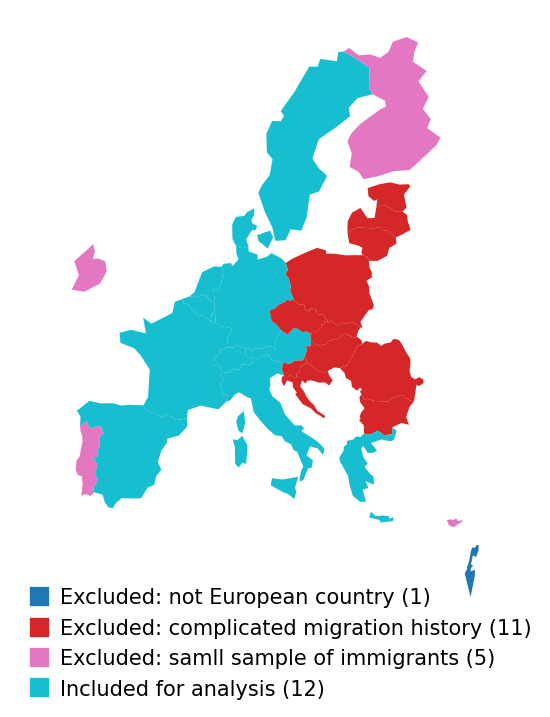

In [48]:
# plot the map of all the countries of interview in the original data

ax = europe_share_all.plot(column="country_type",
                      figsize=(8, 8),
                      legend=True,
                      legend_kwds=dict(fontsize = 15,
                                       frameon=False,
                                       handletextpad=0.02,
                                       markerscale=1.5,
                                       bbox_to_anchor=(0.5, -0.15),
                                       #bbox_to_anchor=(1.5, 0.6),
                                       loc='lower center'))#.set_axis_off()

for ea in ax.get_legend().legend_handles:
    ea.set_marker('s')
    ea.set_markeredgecolor('white')
    ea.set_markeredgewidth(0.5)
ax.figure.axes[0].axis('off')
plt.show()

Austria, Belgium, Denmark, France, Germany, Greece, Italy, Luxembourg, Netherlands, Spain, Sweden, Switzerland

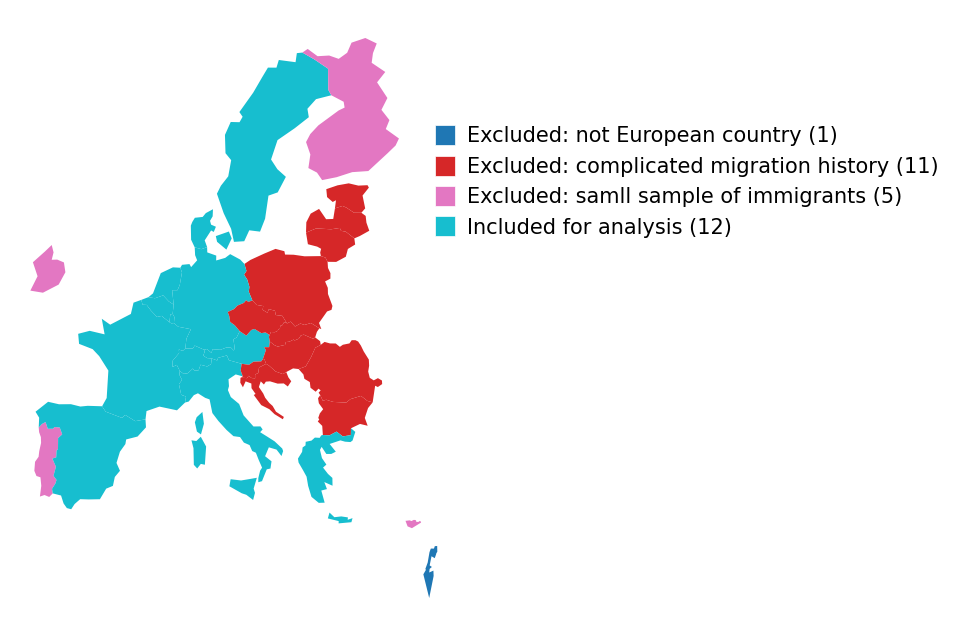

In [49]:
# plot the map of all the countries of interview in the original data

ax = europe_share_all.plot(column="country_type",
                      figsize=(8, 8),
                      legend=True,
                      legend_kwds=dict(fontsize = 15,
                                       frameon=False,
                                       handletextpad=0.02,
                                       markerscale=1.5,
                                       bbox_to_anchor=(1.5, 0.6),
                                       loc='lower center'))#.set_axis_off()

for ea in ax.get_legend().legend_handles:
    ea.set_marker('s')
    ea.set_markeredgecolor('white')
    ea.set_markeredgewidth(0.5)
ax.figure.axes[0].axis('off')
plt.show()

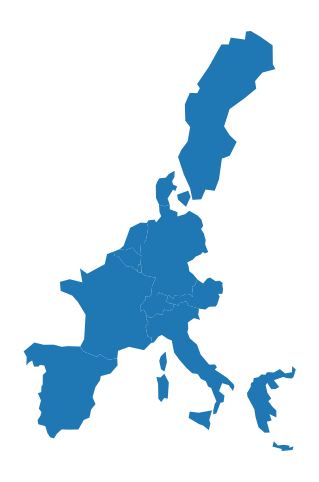

In [50]:
# map without information
europe_immigrants.plot(figsize=(6, 6)).set_axis_off()

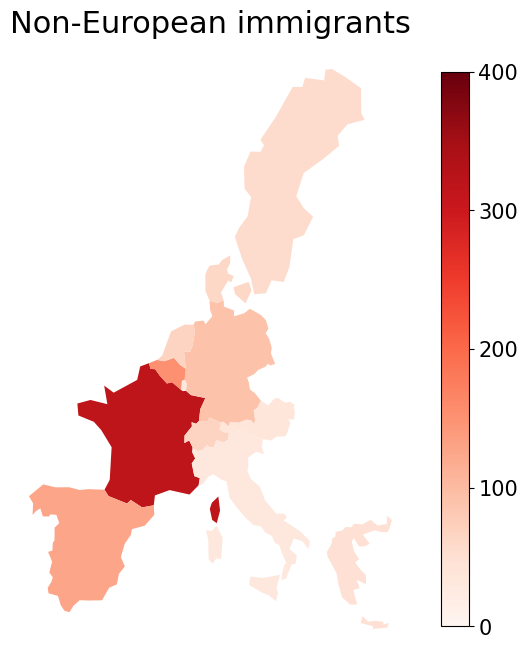

In [51]:
# number of non-European immigrants by country in the sample for analysis
ax = europe_immigrants.plot(
    column="Non-European immigrant",
    legend=True,
    vmin = 0, vmax=400,
    legend_kwds={
        "shrink": 0.9,
        "location":"right",
        'ticks': [0, 100, 200, 300, 400]
    },
    cmap="Reds",
    figsize=(8, 8),
    )
plt.title('Non-European immigrants', fontsize=22)
ax.figure.axes[1].tick_params(labelsize=15)
ax.figure.axes[0].axis('off')
plt.show()

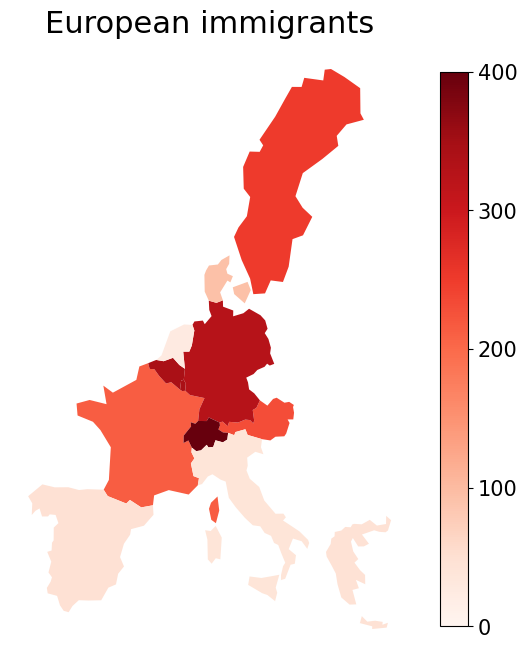

In [52]:
# number of European immigrants by country in the sample for analysis
ax = europe_immigrants.plot(
    column="European immigrant",
    legend=True,
    vmin = 0, vmax=400,
    legend_kwds={
        "shrink": 0.9,
        "location":"right",
        'ticks': [0, 100, 200, 300, 400]
    },
    cmap="Reds",
    figsize=(8, 8)
    )

plt.title('European immigrants', fontsize=22)
ax.figure.axes[1].tick_params(labelsize=15)
ax.figure.axes[0].axis('off')
plt.show()

# Distribution: age when migrating

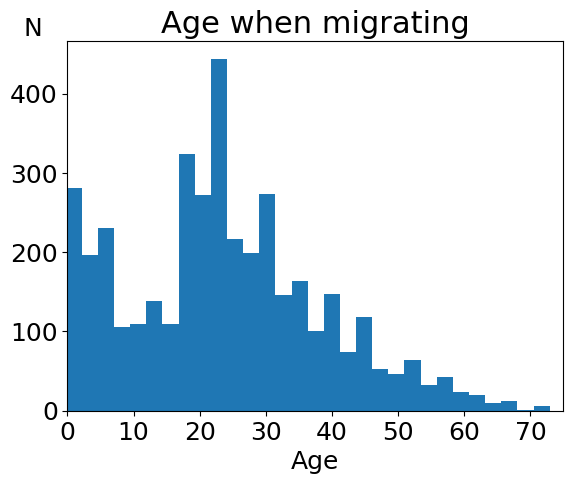

In [ ]:
countries_filter2 = [
    "Austria", "Belgium", "Denmark", "France",
    "Germany", "Greece", "Italy", "Luxembourg",
    "Netherlands", "Spain", "Sweden", "Switzerland"
]

data_wide.loc[data_wide["country"].isin(countries_filter2), ["migrant_age"]].plot.hist(bins = 50)

plt.title('Age when migrating', fontsize=22)
plt.xlabel('Age', fontsize=18)
plt.ylabel('N', fontsize = 18, rotation = 0, ha = 'left', y = 1, labelpad=-10)
plt.xticks(fontsize = 18)
plt.yticks(fontsize = 18)
plt.xlim(0, 75)
plt.legend().remove()
plt.show()

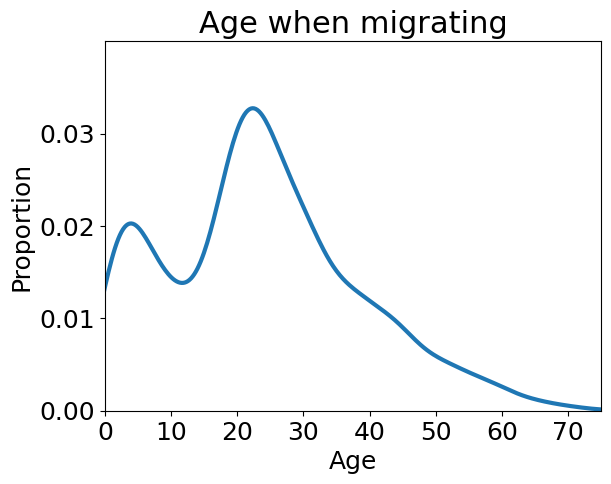

In [238]:
countries_filter2 = [
    "Austria", "Belgium", "Denmark", "France",
    "Germany", "Greece", "Italy", "Luxembourg",
    "Netherlands", "Spain", "Sweden", "Switzerland"
]

data_wide.loc[data_wide["country"].isin(countries_filter2), ["migrant_age"]].plot(kind = "kde", linewidth = 3)
plt.title('Age when migrating', fontsize=22)
plt.xlabel('Age', fontsize=18)
plt.ylabel('Proportion', fontsize = 18)
plt.xticks(fontsize = 18)
plt.yticks(ticks = (0, 0.01, 0.02, 0.03), fontsize = 18)
plt.xlim(0, 75)
plt.ylim(0, 0.04)
plt.legend().remove()
plt.show()

# Sample characteristics: gender, education level, migration age, sample size

In [189]:
sample_migrant_age = data_wide_subset[["native_or_immigrant", "migrant_age"]].groupby("native_or_immigrant").agg("mean").reset_index()
sample_migrant_age["migrant_age"] = sample_migrant_age["migrant_age"].case_when(
    [
        (sample_migrant_age["native_or_immigrant"] == "Native", np.nan)
    ]
).astype(float)

sample_migrant_age = sample_migrant_age.rename(columns = {"migrant_age": "Migration age: mean"})


sample_tertiary = pd.crosstab(data_wide_subset["native_or_immigrant"],
                              data_wide_subset["education_tertiary"],
                              normalize="index"
                              ).reset_index().drop("Lower education", axis = 1).rename_axis(None, axis = 1)


sample_female = pd.crosstab(data_wide_subset["native_or_immigrant"],
                            data_wide_subset["gender"],
                            normalize="index"
                            ).reset_index().drop("Male", axis = 1).rename_axis(None, axis = 1)



sample_native_or_immigrant = data_wide_subset["native_or_immigrant"].value_counts().to_frame("Number of individuals").reset_index()


sample_characteristics = sample_female.merge(sample_tertiary, on = "native_or_immigrant", how = "outer").\
                                       merge(sample_migrant_age, on = "native_or_immigrant", how = "outer").\
                                       merge(sample_native_or_immigrant, on = "native_or_immigrant", how = "outer")

sample_characteristics["Female"] = sample_characteristics["Female"].transform(lambda x: '{:,.0%}'.format(x))
sample_characteristics["Tertiary education"] = sample_characteristics["Tertiary education"].transform(lambda x: '{:,.0%}'.format(x))
sample_characteristics["Number of individuals"] = sample_characteristics["Number of individuals"].apply(lambda x : "{:,}".format(x))
sample_characteristics["Migration age: mean"] = sample_characteristics["Migration age: mean"].apply(lambda x : "{:,.0f}".format(x))
sample_characteristics["Migration age: mean"] = sample_characteristics["Migration age: mean"].case_when(
    [(sample_characteristics["native_or_immigrant"] == "Native", "----")]
)


sample_characteristics["native_or_immigrant"] = sample_characteristics["native_or_immigrant"].case_when(
    [
        (sample_characteristics["native_or_immigrant"] == 'Native', 'Natives'),
        (sample_characteristics["native_or_immigrant"] == 'European immigrant', 'European immigrants'),
        (sample_characteristics["native_or_immigrant"] == 'Non-European immigrant', 'Non-European immigrants')
    ]
)
sample_characteristics["native_or_immigrant"] = sample_characteristics["native_or_immigrant"].astype('category').cat.reorder_categories(
    ['Natives',
     'European immigrants',
     'Non-European immigrants'
     ])

sample_characteristics = sample_characteristics.set_index("native_or_immigrant").transpose().reset_index().rename_axis(None, axis = 1)
sample_characteristics = sample_characteristics.rename(columns = {"index": "Characteristics"})

sample_characteristics = sample_characteristics[["Characteristics", "Natives", "European immigrants", "Non-European immigrants"]]

sample_characteristics

,Characteristics,Natives,European immigrants,Non-European immigrants
0,Female,55%,59%,57%
1,Tertiary education,23%,29%,32%
2,Migration age: mean,----,21,23
3,Number of individuals,"45,110","2,357","1,087"


In [188]:
# save the sample characteristics to docx
sample_characteristics.to_excel('sample_characteristics.xlsx', index = False)


## show with great_tables
from great_tables import GT
GT(sample_characteristics)

Characteristics,Natives,European immigrants,Non-European immigrants
Female,55%,59%,57%
Tertiary education,23%,29%,32%
Migration age: mean,----,21,23
Number of individuals,"45,110","2,357","1,087"


# Distribution of job situation across ages 21-60

In [3]:
occupation_level_long = data_long_subset.copy()[["age", "native_or_immigrant", "occupation_level"]]

occupation_level_long["occupation_level"] = occupation_level_long["occupation_level"].case_when(
    [
        (occupation_level_long["occupation_level"] == 'Other levels', 'Working: other positions'),
        (occupation_level_long["occupation_level"] == 'Professional', 'Working: professional'),
        (occupation_level_long["occupation_level"] == 'Manager', 'Working: manager'),
        (occupation_level_long["occupation_level"] == 'Military services', 'Working: other positions')
    ]
)

occupation_level_long["occupation_level"] = occupation_level_long["occupation_level"].astype('category').cat.reorder_categories(
    ['In education',
     'Retired',
     'Not working',
     'Working: other positions',
     'Working: professional',
     'Working: manager',
     ])

occupation_level_long["native_or_immigrant"] = occupation_level_long["native_or_immigrant"].case_when(
    [
        (occupation_level_long["native_or_immigrant"] == 'Native', 'Natives'),
        (occupation_level_long["native_or_immigrant"] == 'European immigrant', 'European immigrants'),
        (occupation_level_long["native_or_immigrant"] == 'Non-European immigrant', 'Non-European immigrants')
    ]
)


occupation_level_long["native_or_immigrant"] = occupation_level_long["native_or_immigrant"].astype('category').cat.reorder_categories(
    ['Natives',
     'European immigrants',
     'Non-European immigrants'
     ])

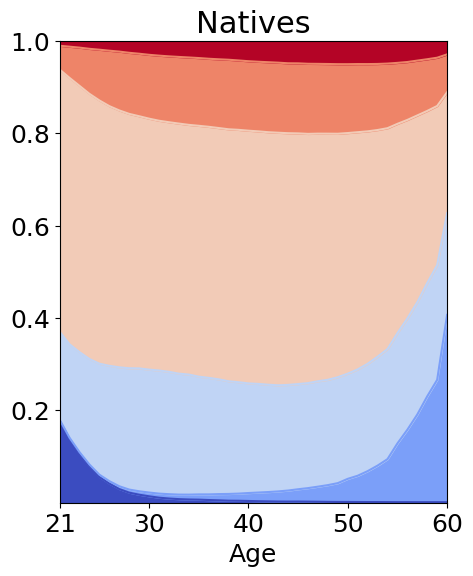

In [253]:
pd.crosstab(occupation_level_long.loc[occupation_level_long["native_or_immigrant"] == "Natives", "age"],
            occupation_level_long.loc[occupation_level_long["native_or_immigrant"] == "Natives", "occupation_level"],
            normalize = "index").plot.area(stacked = True, cmap = "coolwarm", figsize=(5, 6))

plt.title('Natives', fontsize=22)
plt.xlabel('Age', fontsize=18)
plt.ylabel('')
plt.xticks(ticks = (21, 30, 40, 50, 60), fontsize = 18)
plt.yticks(ticks = (0.2, 0.4, 0.6, 0.8, 1.0), fontsize = 18)
plt.ylim(0, 1)
plt.legend().remove()
plt.margins(0)
plt.show()

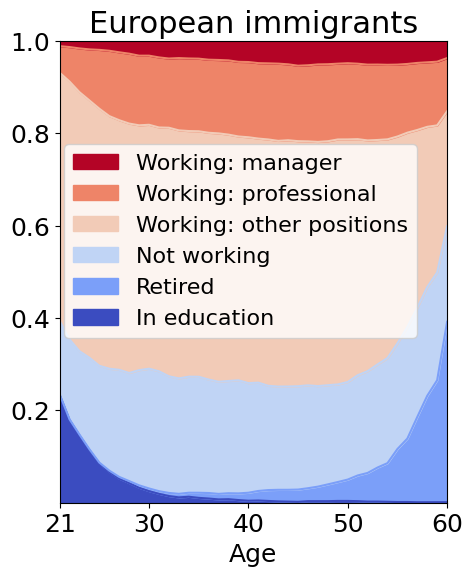

In [281]:
pd.crosstab(occupation_level_long.loc[occupation_level_long["native_or_immigrant"] == "European immigrants", "age"],
            occupation_level_long.loc[occupation_level_long["native_or_immigrant"] == "European immigrants", "occupation_level"],
            normalize = "index").plot.area(stacked = True, cmap = "coolwarm", figsize=(5, 6))

plt.title('European immigrants', fontsize=22)
plt.xlabel('Age', fontsize=18)
plt.ylabel('')
plt.xticks(ticks = (21, 30, 40, 50, 60), fontsize = 18)
plt.yticks(ticks = (0.2, 0.4, 0.6, 0.8, 1.0), fontsize = 18)
plt.ylim(0, 1)
plt.legend(reverse=True,
           fontsize = 16,
           #frameon=False,
           ncol = 1,
           #loc = "center",
           bbox_to_anchor=(0.95, 0.8)).set_title("")
plt.margins(0)
plt.show()

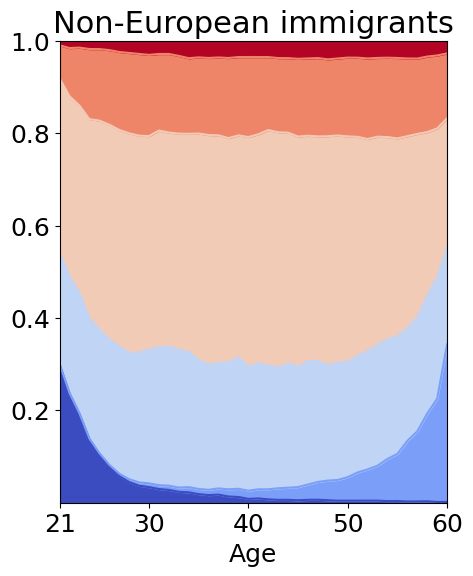

In [282]:
pd.crosstab(occupation_level_long.loc[occupation_level_long["native_or_immigrant"] == "Non-European immigrants", "age"],
            occupation_level_long.loc[occupation_level_long["native_or_immigrant"] == "Non-European immigrants", "occupation_level"],
            normalize = "index").plot.area(stacked = True, cmap = "coolwarm", figsize=(5, 6))

plt.title('Non-European immigrants', fontsize=22)
plt.xlabel('Age', fontsize=18)
plt.ylabel('')
plt.xticks(ticks = (21, 30, 40, 50, 60), fontsize = 18)
plt.yticks(ticks = (0.2, 0.4, 0.6, 0.8, 1.0), fontsize = 18)
plt.ylim(0, 1)
plt.legend().remove()
plt.margins(0)
plt.show()

# Cumulative proportions of ever in a manager/professional job position up to a certain age, from age 20 to 60
# And the age when first in such a position

In [6]:
manager_professional_long = data_long_subset.copy()[["age", "gender", "education_tertiary",
                                                     "native_or_immigrant", "manager_professional_ever_cumulative"]]

manager_professional_long["native_or_immigrant"] = manager_professional_long["native_or_immigrant"].case_when(
    [
        (manager_professional_long["native_or_immigrant"] == 'Native', 'Natives'),
        (manager_professional_long["native_or_immigrant"] == 'European immigrant', 'European immigrants'),
        (manager_professional_long["native_or_immigrant"] == 'Non-European immigrant', 'Non-European immigrants')
    ]
)

manager_professional_long["native_or_immigrant"] = manager_professional_long["native_or_immigrant"].astype('category').cat.reorder_categories(
    ['Natives',
     'European immigrants',
     'Non-European immigrants'
     ])

manager_professional_long["gender_education"] = manager_professional_long["gender"].case_when(
    [
        ((manager_professional_long["gender"] == "Female") & (manager_professional_long["education_tertiary"] == "Tertiary education"), "Female, tertiary"),
        ((manager_professional_long["gender"] == "Female") & (manager_professional_long["education_tertiary"] == "Lower education"), "Female, lower"),
        ((manager_professional_long["gender"] == "Male") & (manager_professional_long["education_tertiary"] == "Tertiary education"), "Male, tertiary"),
        ((manager_professional_long["gender"] == "Male") & (manager_professional_long["education_tertiary"] == "Lower education"), "Male, lower")
    ]
)

manager_professional_long["gender_education"] = manager_professional_long["gender_education"].astype('category').cat.reorder_categories(
    ["Female, tertiary",
     "Female, lower",
     "Male, tertiary",
     "Male, lower"
     ])

### 1. The overall sample

In [7]:
# summarize proportion of ever in a manager or professional job position by age (cumulative) and by immigrant groups

# compile the list of dataframes to merge
manager_professional_long_by_immigrant_frames = []

immigrant_group = ["Natives", "European immigrants", "Non-European immigrants"]
immigrant_short = ["native", "euimm", "neimm"]

for group, short in zip(immigrant_group, immigrant_short):
    
    df = pd.crosstab(
        manager_professional_long.loc[manager_professional_long["native_or_immigrant"] == f"{group}", "age"],
        manager_professional_long.loc[manager_professional_long["native_or_immigrant"] == f"{group}", "manager_professional_ever_cumulative"],
        normalize = "index").reset_index()
    
    globals()[f"manager_professional_{short}"] = df.melt(
        id_vars = 'age',
        value_vars = [c for c in list(df) if c != "age"],
        value_name = "proportion"
    )

    globals()[f"manager_professional_{short}"]["native_or_immigrant"] = f"{group}"
    
    print(f"Table manager_professional_{short} created successfully!")

    # compile the list of dataframes to merge
    manager_professional_long_by_immigrant_frames.append(globals()[f"manager_professional_{short}"])

# merge all 3 groups
manager_professional_long_by_immigrant = reduce(lambda  left, right: pd.concat([left, right], ignore_index=True), manager_professional_long_by_immigrant_frames)
print("All dataframes merged!")

manager_professional_long_by_immigrant = manager_professional_long_by_immigrant[manager_professional_long_by_immigrant["manager_professional_ever_cumulative"] == 1]
manager_professional_long_by_immigrant = manager_professional_long_by_immigrant.drop("manager_professional_ever_cumulative", axis = 1)

Table manager_professional_native created successfully!
Table manager_professional_euimm created successfully!
Table manager_professional_neimm created successfully!
All dataframes merged!


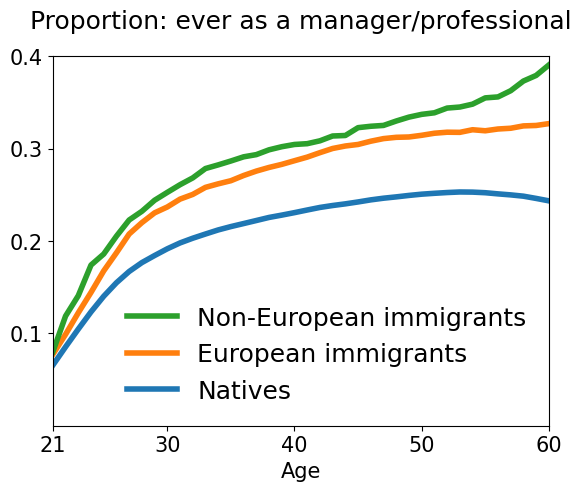

In [289]:
sns.lineplot(data = manager_professional_long_by_immigrant,
             x = "age",
             y = "proportion",
             hue = "native_or_immigrant",
             linewidth = 4
            )

plt.title('Proportion: ever as a manager/professional', fontsize=18, pad=20)
plt.xlabel('Age', fontsize=15)
plt.ylabel('')
plt.xticks(ticks = (21, 30, 40, 50, 60), fontsize = 15)
plt.yticks(ticks = (0.1, 0.2, 0.3, 0.4), fontsize = 15)
plt.ylim(0, 0.4)
plt.legend(reverse = True, frameon=False, loc = "lower right", fontsize = 18).set_title("")
plt.margins(0)
plt.show()

C:\Users\Jianji Chen\AppData\Local\Temp\ipykernel_34276\3684701483.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])


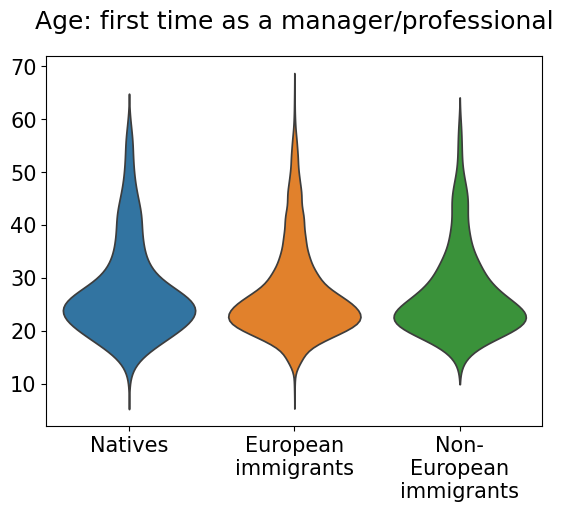

In [ ]:
## age when first in such a position



fig, ax = plt.subplots()

sns.violinplot(data = data_wide_subset,
               x = "native_or_immigrant",
               y = "manager_professional_1stage",
               inner = None,
               hue = "native_or_immigrant",
            )

plt.title('Age: first time as a manager/professional', fontsize=18, pad=20)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])
plt.legend().remove()
plt.show()

### 2. By Gender

In [8]:
# summarize proportion of ever in a manager or professional job position by age (cumulative) and by immigrant groups and gender

# compile the list of dataframes to merge
manager_professional_long_by_immigrant_gender_frames = []

immigrant_group = ["Natives", "European immigrants", "Non-European immigrants"]
immigrant_short = ["native", "euimm", "neimm"]

for group, short in zip(immigrant_group, immigrant_short):

    for gender in ["Female", "Male"]:
    
        df = pd.crosstab(
            manager_professional_long.loc[(manager_professional_long["native_or_immigrant"] == f"{group}") & (manager_professional_long["gender"] == f"{gender}"), "age"],
            manager_professional_long.loc[(manager_professional_long["native_or_immigrant"] == f"{group}") & (manager_professional_long["gender"] == f"{gender}"), "manager_professional_ever_cumulative"],
            normalize = "index").reset_index()
        
        globals()[f"manager_professional_{short}_{gender}"] = df.melt(
            id_vars = 'age',
            value_vars = [c for c in list(df) if c != "age"],
            value_name = "proportion"
        )

        globals()[f"manager_professional_{short}_{gender}"]["native_or_immigrant"] = f"{group}"

        globals()[f"manager_professional_{short}_{gender}"]["gender"] = f"{gender}"
        
        print(f"Table manager_professional_{short}_{gender} created successfully!")

        # compile the list of dataframes to merge
        manager_professional_long_by_immigrant_gender_frames.append(globals()[f"manager_professional_{short}_{gender}"])

# merge all 3 groups
manager_professional_long_by_immigrant_gender = reduce(lambda  left, right: pd.concat([left, right], ignore_index=True), manager_professional_long_by_immigrant_gender_frames)
print("All dataframes merged!")

manager_professional_long_by_immigrant_gender = manager_professional_long_by_immigrant_gender[manager_professional_long_by_immigrant_gender["manager_professional_ever_cumulative"] == 1]
manager_professional_long_by_immigrant_gender = manager_professional_long_by_immigrant_gender.drop("manager_professional_ever_cumulative", axis = 1)

Table manager_professional_native_Female created successfully!
Table manager_professional_native_Male created successfully!
Table manager_professional_euimm_Female created successfully!
Table manager_professional_euimm_Male created successfully!
Table manager_professional_neimm_Female created successfully!
Table manager_professional_neimm_Male created successfully!
All dataframes merged!


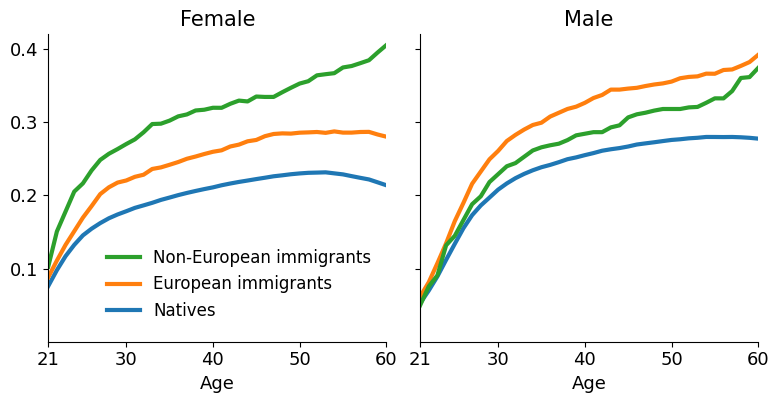

In [295]:

g_immigrant_gender = sns.FacetGrid(manager_professional_long_by_immigrant_gender, col = "gender",
                                   height = 4, aspect = 1)

g_immigrant_gender.map_dataframe(sns.lineplot,
                                 x = "age",
                                 y = "proportion",
                                 hue = "native_or_immigrant",
                                 linewidth = 3
                                 )

g_immigrant_gender.set_titles('{col_name}', size=15)
g_immigrant_gender.set_xlabels("Age", fontsize=13)
g_immigrant_gender.set_ylabels("")
g_immigrant_gender.set(xticks=(21, 30, 40, 50, 60))
g_immigrant_gender.set(yticks=(0.1, 0.2, 0.3, 0.4))
g_immigrant_gender.tick_params(axis='both', labelsize=13)
plt.xlim(21, 60)
plt.ylim(0, 0.42)
plt.legend(reverse = True, frameon=False, bbox_to_anchor=(-0.1, 0.35), fontsize = 12).set_title("")
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.margins(0)
plt.show()

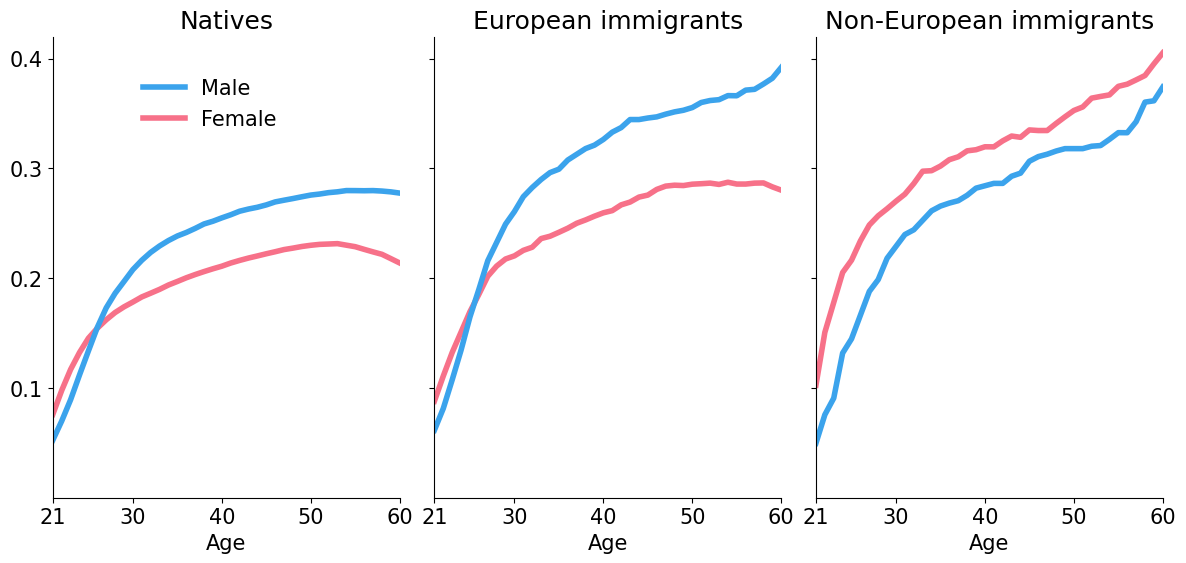

In [88]:
g_immigrant_gender = sns.FacetGrid(manager_professional_long_by_immigrant_gender, col = "native_or_immigrant",
                                   height = 4, aspect = 1)

g_immigrant_gender.map_dataframe(sns.lineplot,
                                 x = "age",
                                 y = "proportion",
                                 hue = "gender",
                                 linewidth = 4,
                                 alpha = 1,
                                 palette=['#f77189', '#3ba3ec']
                                 )

g_immigrant_gender.set_titles('{col_name}', size=18)
g_immigrant_gender.set_xlabels("Age", fontsize=15)
g_immigrant_gender.set_ylabels("")
g_immigrant_gender.set(xticks=(21, 30, 40, 50, 60))
g_immigrant_gender.set(yticks=(0.1, 0.2, 0.3, 0.4))
g_immigrant_gender.tick_params(axis='both', labelsize=15)
plt.xlim(21, 60)
plt.ylim(0, 0.42)
plt.legend(reverse = True, frameon=False, bbox_to_anchor=(-1.5, 0.95), fontsize = 15).set_title("")
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.margins(0)
g_immigrant_gender.figure.set_size_inches(12,6)
plt.show()

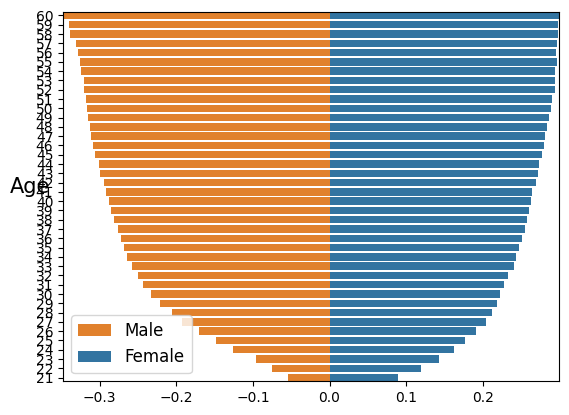

In [49]:
### Not necessary

manager_professional_long_by_immigrant_gender_pyramid = manager_professional_long_by_immigrant_gender.copy()
manager_professional_long_by_immigrant_gender_pyramid["proportion"] = manager_professional_long_by_immigrant_gender_pyramid["proportion"].case_when(
    [
        (manager_professional_long_by_immigrant_gender_pyramid["gender"] == "Male", manager_professional_long_by_immigrant_gender_pyramid["proportion"] * (-1))
    ]
)


fig, ax = plt.subplots()
sns.barplot(data=manager_professional_long_by_immigrant_gender_pyramid,
            x='proportion', y='age',
            hue='gender', orient='horizontal', 
            dodge=False,
            errorbar=None)

ax.invert_yaxis()
plt.ylabel('Age', fontsize=15, rotation = 0)
plt.xlabel('')
#plt.yticks(ticks = (21, 25, 30, 35, 40, 45, 50, 55, 60), fontsize = 15)
#plt.xticks(ticks = (-0.4, -0.3, -0.2, -0.1, 0, 0.1, 0.2, 0.3), fontsize = 15)
#plt.ylim(1, 60)
#plt.xlim(-0.42, 0.35)
plt.legend(reverse = True, loc = "lower left", fontsize = 12).set_title("")
plt.margins(0)
plt.show()

C:\Users\Jianji Chen\AppData\Local\Temp\ipykernel_36548\2958391828.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])


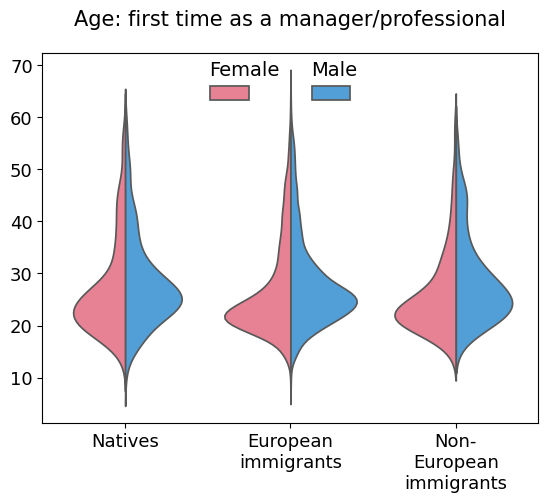

In [87]:
## age when first in such a position



fig, ax = plt.subplots()

sns.violinplot(data = data_wide_subset,
               x = "native_or_immigrant",
               y = "manager_professional_1stage",
               inner = None,
               hue = "gender",
               split=True,
               palette=['#f77189', '#3ba3ec']
            )

plt.title('Age: first time as a manager/professional', fontsize=15, pad=20)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)
ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])
legend = fig.legend(reverse = False,
                    frameon=False,
                    bbox_to_anchor=(0.73, 0.85),
                    ncol = 2,
                    columnspacing=-1.2,
                    fontsize = 14)
for txt in legend.get_texts():
    txt.set_ha("center") # horizontal alignment of text item
    txt.set_x(-55) # x-position
    txt.set_y(25) # y-position
#plt.legend(reverse = False, frameon=False, loc = "upper left", ncol = 2, fontsize = 13).set_title("")
plt.legend().remove()
plt.show()

### 3. By education level

In [7]:
# summarize proportion of ever in a manager or professional job position by age (cumulative) and by immigrant groups and education

# compile the list of dataframes to merge
manager_professional_long_by_immigrant_education_frames = []

immigrant_group = ["Natives", "European immigrants", "Non-European immigrants"]
immigrant_short = ["native", "euimm", "neimm"]

for group, short in zip(immigrant_group, immigrant_short):

    for education, edu in zip(["Tertiary education", "Lower education"], ["tertiary", "lower"]):
    
        df = pd.crosstab(
            manager_professional_long.loc[(manager_professional_long["native_or_immigrant"] == f"{group}") & (manager_professional_long["education_tertiary"] == f"{education}"), "age"],
            manager_professional_long.loc[(manager_professional_long["native_or_immigrant"] == f"{group}") & (manager_professional_long["education_tertiary"] == f"{education}"), "manager_professional_ever_cumulative"],
            normalize = "index").reset_index()
        
        globals()[f"manager_professional_{short}_{edu}"] = df.melt(
            id_vars = 'age',
            value_vars = [c for c in list(df) if c != "age"],
            value_name = "proportion"
        )

        globals()[f"manager_professional_{short}_{edu}"]["native_or_immigrant"] = f"{group}"

        globals()[f"manager_professional_{short}_{edu}"]["education_tertiary"] = f"{education}"
        
        print(f"Table manager_professional_{short}_{edu} created successfully!")

        # compile the list of dataframes to merge
        manager_professional_long_by_immigrant_education_frames.append(globals()[f"manager_professional_{short}_{edu}"])

# merge all 3 groups
manager_professional_long_by_immigrant_education = reduce(lambda  left, right: pd.concat([left, right], ignore_index=True), manager_professional_long_by_immigrant_education_frames)
print("All dataframes merged!")

manager_professional_long_by_immigrant_education = manager_professional_long_by_immigrant_education[manager_professional_long_by_immigrant_education["manager_professional_ever_cumulative"] == 1]
manager_professional_long_by_immigrant_education = manager_professional_long_by_immigrant_education.drop("manager_professional_ever_cumulative", axis = 1)

Table manager_professional_native_tertiary created successfully!
Table manager_professional_native_lower created successfully!
Table manager_professional_euimm_tertiary created successfully!
Table manager_professional_euimm_lower created successfully!
Table manager_professional_neimm_tertiary created successfully!
Table manager_professional_neimm_lower created successfully!
All dataframes merged!


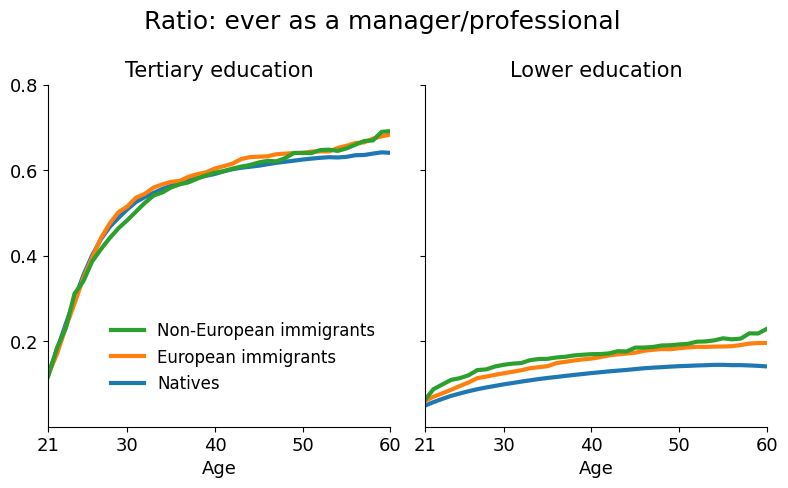

In [197]:

g_immigrant_education = sns.FacetGrid(manager_professional_long_by_immigrant_education, col = "education_tertiary",
                                   height = 4, aspect = 1)

g_immigrant_education.map_dataframe(sns.lineplot,
                                 x = "age",
                                 y = "proportion",
                                 hue = "native_or_immigrant",
                                 linewidth = 3
                                 )

g_immigrant_education.set_titles('{col_name}', size=15)
g_immigrant_education.fig.subplots_adjust(top=0.83) # adjust the Figure in rp
g_immigrant_education.fig.suptitle('Ratio: ever as a manager/professional', fontsize=18)
g_immigrant_education.set_xlabels("Age", fontsize=13)
g_immigrant_education.set_ylabels("")
g_immigrant_education.set(xticks=(21, 30, 40, 50, 60))
g_immigrant_education.set(yticks=np.arange(0.2, 0.9, step=0.2))
g_immigrant_education.tick_params(axis='both', labelsize=13)
plt.xlim(21, 60)
plt.ylim(0, 0.8)
plt.legend(reverse = True, frameon=False, bbox_to_anchor=(-0.1, 0.35), fontsize = 12).set_title("")
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.margins(0)
g_immigrant_education.figure.set_size_inches(8,5)
plt.show()

In [8]:
print(sns.color_palette("husl").as_hex())

['#f77189', '#bb9832', '#50b131', '#36ada4', '#3ba3ec', '#e866f4']


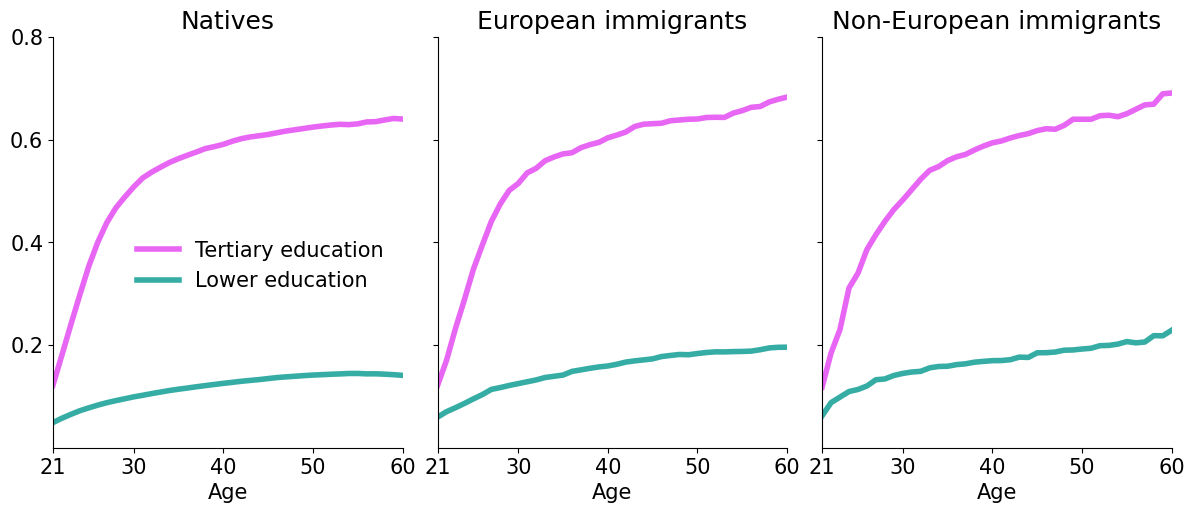

In [9]:
g_immigrant_education = sns.FacetGrid(manager_professional_long_by_immigrant_education, col = "native_or_immigrant",
                                   height = 4, aspect = 1)

g_immigrant_education.map_dataframe(sns.lineplot,
                                 x = "age",
                                 y = "proportion",
                                 hue = "education_tertiary",
                                 linewidth = 4,
                                 alpha = 1,
                                 palette=['#e866f4', '#36ada4']
                                 )

g_immigrant_education.set_titles('{col_name}', size=18)
g_immigrant_education.fig.subplots_adjust(top=0.83) # adjust the Figure in rp
#g_immigrant_education.fig.suptitle('Ratio: ever as a manager/professional', fontsize=18)
g_immigrant_education.set_xlabels("Age", fontsize=15)
g_immigrant_education.set_ylabels("")
g_immigrant_education.set(xticks=(21, 30, 40, 50, 60))
g_immigrant_education.set(yticks=np.arange(0.2, 0.9, step=0.2))
g_immigrant_education.tick_params(axis='both', labelsize=15)
plt.xlim(21, 60)
plt.ylim(0, 0.8)
plt.legend(reverse = False, frameon=False, bbox_to_anchor=(-1.2, 0.55), fontsize = 15).set_title("")
plt.subplots_adjust(hspace=0.1, wspace=0.1)
plt.margins(0)
g_immigrant_education.figure.set_size_inches(12,6)
plt.show()

C:\Users\Jianji Chen\AppData\Local\Temp\ipykernel_15300\2766778567.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])


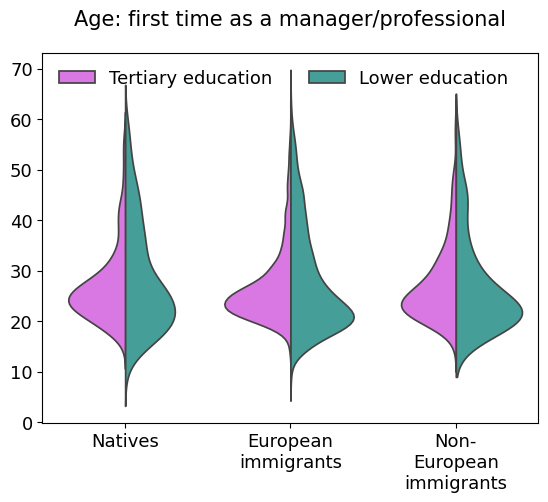

In [10]:
## age when first in such a position



fig, ax = plt.subplots()

sns.violinplot(data = data_wide_subset,
               x = "native_or_immigrant",
               y = "manager_professional_1stage",
               inner = None,
               hue = "education_tertiary",
               split=True,
               palette=['#e866f4', '#36ada4']
            )

plt.title('Age: first time as a manager/professional', fontsize=15, pad=20)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize = 13)
plt.xticks(fontsize = 13)
ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])
plt.legend(reverse = False, frameon=False, loc = "upper left", ncol = 2, fontsize = 13).set_title("")
plt.show()

### 4. By gender and education level

In [11]:
# summarize proportion of ever in a manager or professional job position by age (cumulative) and by immigrant groups and gender & education

# compile the list of dataframes to merge
manager_professional_long_by_immigrant_gender_education_frames = []

immigrant_group = ["Natives", "European immigrants", "Non-European immigrants"]
immigrant_short = ["native", "euimm", "neimm"]

for group, short in zip(immigrant_group, immigrant_short):

    for gender_education, gen_edu in zip(manager_professional_long.gender_education.unique(), ["female_tertiary", "female_other", "male_tertiary", "male_other"]):
    
        df = pd.crosstab(
            manager_professional_long.loc[(manager_professional_long["native_or_immigrant"] == f"{group}") & (manager_professional_long["gender_education"] == f"{gender_education}"), "age"],
            manager_professional_long.loc[(manager_professional_long["native_or_immigrant"] == f"{group}") & (manager_professional_long["gender_education"] == f"{gender_education}"), "manager_professional_ever_cumulative"],
            normalize = "index").reset_index()
        
        globals()[f"manager_professional_{short}_{gen_edu}"] = df.melt(
            id_vars = 'age',
            value_vars = [c for c in list(df) if c != "age"],
            value_name = "proportion"
        )

        globals()[f"manager_professional_{short}_{gen_edu}"]["native_or_immigrant"] = f"{group}"

        globals()[f"manager_professional_{short}_{gen_edu}"]["gender_education"] = f"{gender_education}"
        
        print(f"Table manager_professional_{short}_{gen_edu} created successfully!")

        # compile the list of dataframes to merge
        manager_professional_long_by_immigrant_gender_education_frames.append(globals()[f"manager_professional_{short}_{gen_edu}"])

# merge all 3 groups
manager_professional_long_by_immigrant_gender_education = reduce(lambda  left, right: pd.concat([left, right], ignore_index=True), manager_professional_long_by_immigrant_gender_education_frames)
print("All dataframes merged!")

manager_professional_long_by_immigrant_gender_education = manager_professional_long_by_immigrant_gender_education[manager_professional_long_by_immigrant_gender_education["manager_professional_ever_cumulative"] == 1]
manager_professional_long_by_immigrant_gender_education = manager_professional_long_by_immigrant_gender_education.drop("manager_professional_ever_cumulative", axis = 1)

manager_professional_long_by_immigrant_gender_education["gender_education"] = manager_professional_long_by_immigrant_gender_education["gender_education"].astype('category').cat.reorder_categories(
    ["Female, tertiary",
     "Male, tertiary",
     "Female, lower",
     "Male, lower"
     ])

Table manager_professional_native_female_tertiary created successfully!
Table manager_professional_native_female_other created successfully!
Table manager_professional_native_male_tertiary created successfully!
Table manager_professional_native_male_other created successfully!
Table manager_professional_euimm_female_tertiary created successfully!
Table manager_professional_euimm_female_other created successfully!
Table manager_professional_euimm_male_tertiary created successfully!
Table manager_professional_euimm_male_other created successfully!
Table manager_professional_neimm_female_tertiary created successfully!
Table manager_professional_neimm_female_other created successfully!
Table manager_professional_neimm_male_tertiary created successfully!
Table manager_professional_neimm_male_other created successfully!
All dataframes merged!


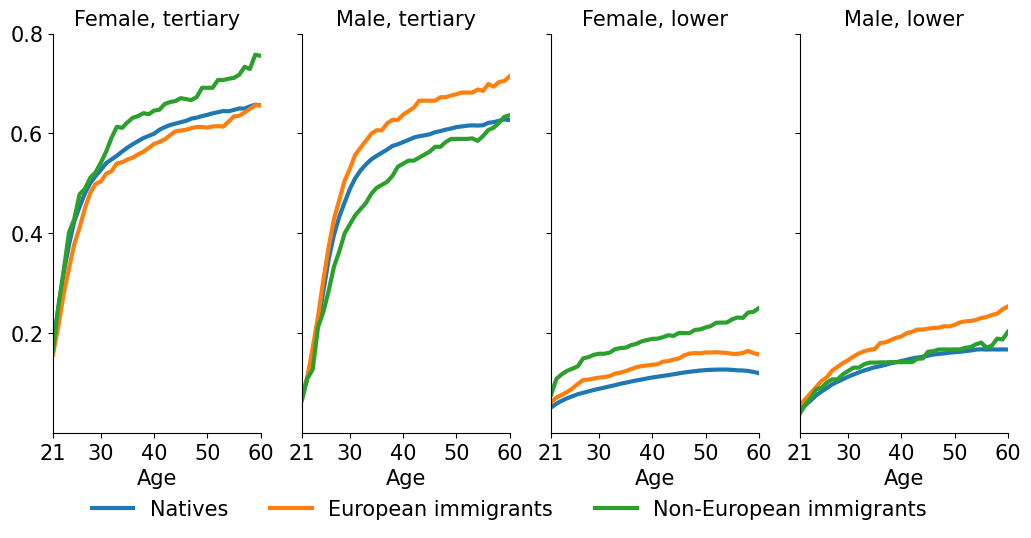

In [12]:
g_immigrant_gender_education = sns.FacetGrid(manager_professional_long_by_immigrant_gender_education,
                                             col = "gender_education",
                                             #sharex=False, sharey=False,
                                             height = 3, aspect = 1.5, col_wrap=4)

g_immigrant_gender_education.map_dataframe(sns.lineplot,
                                 x = "age",
                                 y = "proportion",
                                 hue = "native_or_immigrant",
                                 linewidth = 3
                                 )

g_immigrant_gender_education.set_titles('{col_name}', size=15)
g_immigrant_gender_education.fig.subplots_adjust(top=0.86) # adjust the Figure in rp
#g_immigrant_gender_education.fig.suptitle('Ratio: ever as a manager/professional', fontsize=18)
g_immigrant_gender_education.set_xlabels("Age", fontsize=15)
g_immigrant_gender_education.set_ylabels("")
g_immigrant_gender_education.set(xticks=(21, 30, 40, 50, 60))
g_immigrant_gender_education.set(yticks=np.arange(0.2, 0.9, step=0.2))
g_immigrant_gender_education.tick_params(axis='both', labelsize=15)
plt.xlim(21, 60)
plt.ylim(0, 0.8)
plt.legend(reverse = False, frameon=False, bbox_to_anchor=(0.7, -0.12), ncol = 3, fontsize = 15).set_title("")
#plt.legend(reverse = True, frameon=False, bbox_to_anchor=(-1, 1), ncol = 1, fontsize = 15).set_title("")
plt.subplots_adjust(hspace=0, wspace=0.2)
plt.margins(0)
g_immigrant_gender_education.figure.set_size_inches(10,6)
plt.show()

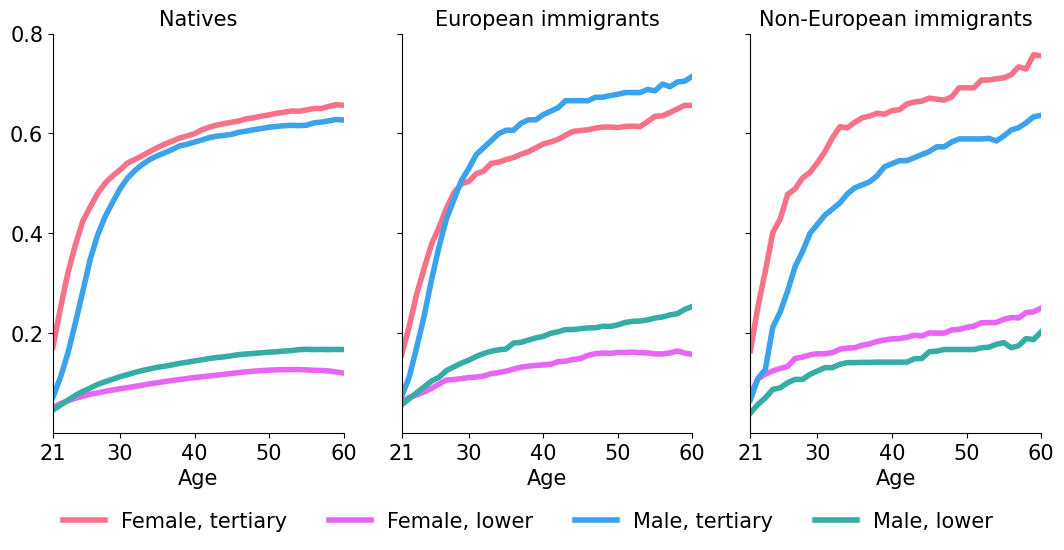

In [80]:
g_immigrant_gender_education = sns.FacetGrid(manager_professional_long_by_immigrant_gender_education, col = "native_or_immigrant",
                                             height = 3, aspect = 1.5, col_wrap=4)

g_immigrant_gender_education.map_dataframe(sns.lineplot,
                                 x = "age",
                                 y = "proportion",
                                 hue = "gender_education",
                                 linewidth = 4,
                                 alpha = 1,
                                 palette = ['#f77189', '#e866f4', '#3ba3ec', '#36ada4']
                                 )

g_immigrant_gender_education.set_titles('{col_name}', size=15)
g_immigrant_gender_education.fig.subplots_adjust(top=0.86) # adjust the Figure in rp
#g_immigrant_gender_education.fig.suptitle('Ratio: ever as a manager/professional', fontsize=18)
g_immigrant_gender_education.set_xlabels("Age", fontsize=15)
g_immigrant_gender_education.set_ylabels("")
g_immigrant_gender_education.set(xticks=(21, 30, 40, 50, 60))
g_immigrant_gender_education.set(yticks=np.arange(0.2, 0.9, step=0.2))
g_immigrant_gender_education.tick_params(axis='both', labelsize=15)
plt.xlim(21, 60)
plt.ylim(0, 0.8)
plt.legend(reverse = False, frameon=False, bbox_to_anchor=(0.9, -0.15), ncol = 4, fontsize = 15).set_title("")
plt.subplots_adjust(hspace=0, wspace=0.2)
plt.margins(0)
g_immigrant_gender_education.figure.set_size_inches(14,6)
plt.show()

In [74]:
print(sns.color_palette("husl").as_hex())

['#f77189', '#bb9832', '#50b131', '#36ada4', '#3ba3ec', '#e866f4']


In [55]:
data_wide_subset_4group = data_wide_subset.copy()

data_wide_subset_4group["gender_education"] = data_wide_subset_4group["gender"].case_when(
    [
        ((data_wide_subset_4group["gender"] == "Female") & (data_wide_subset_4group["education_tertiary"] == "Tertiary education"), "Female, tertiary"),
        ((data_wide_subset_4group["gender"] == "Female") & (data_wide_subset_4group["education_tertiary"] == "Lower education"), "Female, lower"),
        ((data_wide_subset_4group["gender"] == "Male") & (data_wide_subset_4group["education_tertiary"] == "Tertiary education"), "Male, tertiary"),
        ((data_wide_subset_4group["gender"] == "Male") & (data_wide_subset_4group["education_tertiary"] == "Lower education"), "Male, lower")
    ]
)

data_wide_subset_4group["gender_education"] = data_wide_subset_4group["gender_education"].astype('category').cat.reorder_categories(
    ["Female, tertiary",
     "Female, lower",
     "Male, tertiary",
     "Male, lower"
     ])

C:\Users\Jianji Chen\AppData\Local\Temp\ipykernel_15300\1287299100.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])


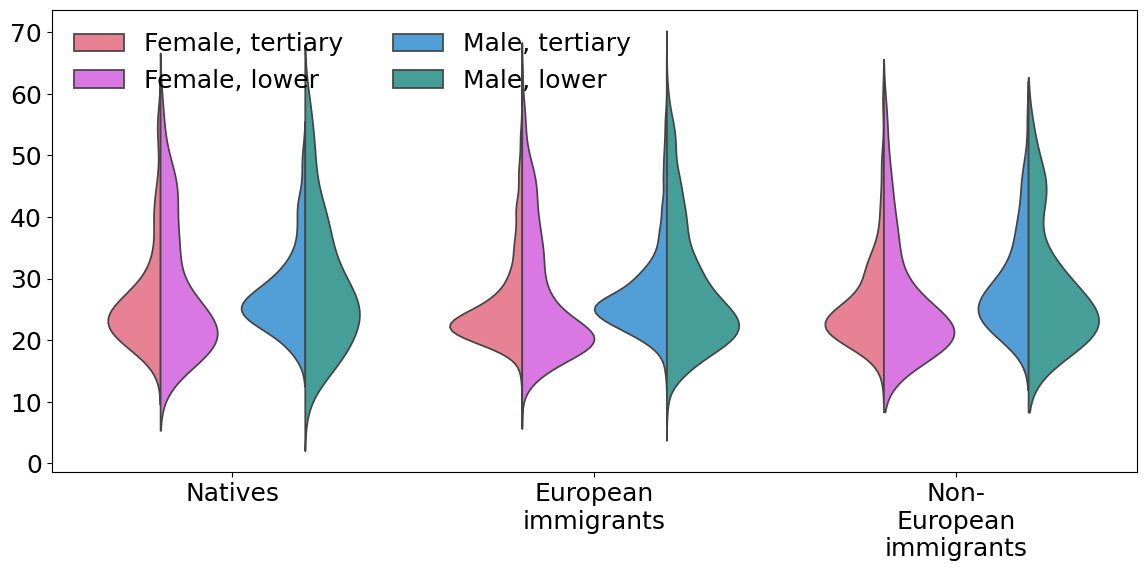

In [56]:
## age when first in such a position



fig, ax = plt.subplots()

sns.violinplot(data = data_wide_subset_4group,
               x = "native_or_immigrant",
               y = "manager_professional_1stage",
               inner = None,
               hue = "gender_education",
               split=True,
               palette=['#f77189', '#e866f4', '#3ba3ec', '#36ada4']
            )

#plt.title('Age: first time as a manager/professional', fontsize=18, pad=20)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])
plt.legend(reverse = False, frameon=False, loc = "upper left", ncol = 2, fontsize = 18).set_title("")
#plt.legend(reverse = False, frameon=False, bbox_to_anchor=(0.5, 0.8), ncol = 2, fontsize = 16).set_title("")

fig.figure.set_size_inches(14,6)
plt.show()

# Maps by country: possibility of ever in a manager/professional position: ratio of immigrants to natives

In [31]:
# summarize proportion of ever in a manager or professional job position at age 50 (cumulative)  by immigrant groups and by country

data_long_subset_age50 = data_long_subset.copy()[data_long_subset["age"] == 50]

data_long_subset_age50["native_or_immigrant"] = data_long_subset_age50["native_or_immigrant"].case_when(
    [
        (data_long_subset_age50["native_or_immigrant"] == 'Native', 'Natives'),
        (data_long_subset_age50["native_or_immigrant"] == 'European immigrant', 'European immigrants'),
        (data_long_subset_age50["native_or_immigrant"] == 'Non-European immigrant', 'Non-European immigrants')
    ]
)

# compile the list of dataframes to merge
manager_professional_age50_by_immigrant_country_frames = []

immigrant_group = ["Natives", "European immigrants", "Non-European immigrants"]
immigrant_short = ["native", "euimm", "neimm"]

for group, short in zip(immigrant_group, immigrant_short):
    
    df = pd.crosstab(
        data_long_subset_age50.loc[data_long_subset_age50["native_or_immigrant"] == f"{group}", "country"],
        data_long_subset_age50.loc[data_long_subset_age50["native_or_immigrant"] == f"{group}", "manager_professional_ever_cumulative"],
        normalize = "index").reset_index()
    
    globals()[f"manager_professional_{short}"] = df.melt(
        id_vars = 'country',
        value_vars = [c for c in list(df) if c != "country"],
        value_name = "proportion"
    )

    globals()[f"manager_professional_{short}"]["native_or_immigrant"] = f"{group}"
    
    print(f"Table manager_professional_{short} created successfully!")

    # compile the list of dataframes to merge
    manager_professional_age50_by_immigrant_country_frames.append(globals()[f"manager_professional_{short}"])

# merge all 3 groups
manager_professional_age50_by_immigrant_country = reduce(lambda  left, right: pd.concat([left, right], ignore_index=True), manager_professional_age50_by_immigrant_country_frames)
print("All dataframes merged!")

manager_professional_age50_by_immigrant_country = manager_professional_age50_by_immigrant_country[manager_professional_age50_by_immigrant_country["manager_professional_ever_cumulative"] == 1]
manager_professional_age50_by_immigrant_country = manager_professional_age50_by_immigrant_country.drop("manager_professional_ever_cumulative", axis = 1)

Table manager_professional_native created successfully!
Table manager_professional_euimm created successfully!
Table manager_professional_neimm created successfully!
All dataframes merged!


In [32]:
# summarize proportion of ever in a manager or professional job position by age 50 (cumulative)  by immigrant groups and by country

data_long_subset_age50 = data_long_subset.copy()[data_long_subset["age"] == 50]

data_long_subset_age50["native_or_immigrant"] = data_long_subset_age50["native_or_immigrant"].case_when(
    [
        (data_long_subset_age50["native_or_immigrant"] == 'Native', 'Natives'),
        (data_long_subset_age50["native_or_immigrant"] == 'European immigrant', 'European immigrants'),
        (data_long_subset_age50["native_or_immigrant"] == 'Non-European immigrant', 'Non-European immigrants')
    ]
)

# compile the list of dataframes to merge
manager_professional_age50_by_immigrant_country_frames = []

immigrant_group = ["Natives", "European immigrants", "Non-European immigrants"]
immigrant_short = ["native", "euimm", "neimm"]

for group, short in zip(immigrant_group, immigrant_short):
    
    df = pd.crosstab(
        data_long_subset_age50.loc[data_long_subset_age50["native_or_immigrant"] == f"{group}", "country"],
        data_long_subset_age50.loc[data_long_subset_age50["native_or_immigrant"] == f"{group}", "manager_professional_ever_cumulative"],
        normalize = "index").reset_index()
    
    globals()[f"manager_professional_{short}"] = df.drop(0, axis = 1).rename(columns = {1: f"{short}"})
    
    print(f"Table manager_professional_{short} created successfully!")

    # compile the list of dataframes to merge
    manager_professional_age50_by_immigrant_country_frames.append(globals()[f"manager_professional_{short}"])

# merge all 3 groups
manager_professional_age50_by_immigrant_country = reduce(lambda  left, right: pd.merge(left, right, on = ['country'], how = 'outer'), manager_professional_age50_by_immigrant_country_frames)
print("All dataframes merged!")

manager_professional_age50_by_immigrant_country["euimm_to_native"] = manager_professional_age50_by_immigrant_country["euimm"] / manager_professional_age50_by_immigrant_country["native"]
manager_professional_age50_by_immigrant_country["neimm_to_native"] = manager_professional_age50_by_immigrant_country["neimm"] / manager_professional_age50_by_immigrant_country["native"]

Table manager_professional_native created successfully!
Table manager_professional_euimm created successfully!
Table manager_professional_neimm created successfully!
All dataframes merged!


In [53]:
europe_immigrants_to_natives = pd.merge(europe_immigrants,
                                        manager_professional_age50_by_immigrant_country.rename(columns = {"country": "ADMIN"}),
                                        on='ADMIN', how = "left")

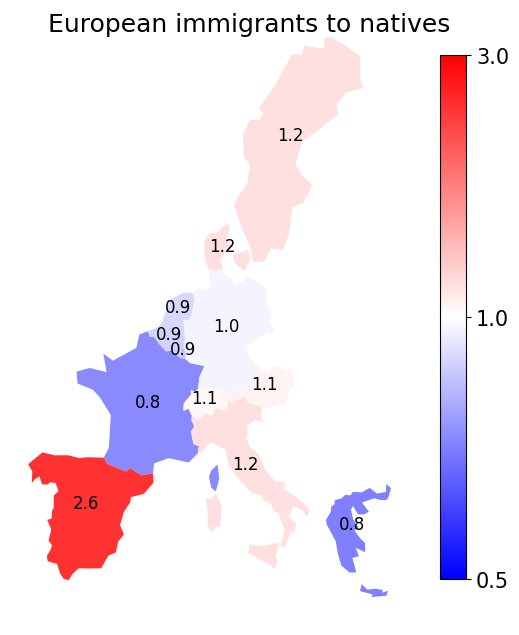

In [54]:
# Ratio: European immigrants to natives by country

from matplotlib.colors import TwoSlopeNorm

ax = europe_immigrants_to_natives.plot(
    column="euimm_to_native",
    categorical=False,
    legend=True,
    norm = TwoSlopeNorm(vmin = 0.5, vcenter=1, vmax=3),
    legend_kwds={
        "shrink": 0.85,
        "location": "right",
        'ticks': [0.5, 1, 3]
        },
    cmap = "bwr",
    figsize=(8, 8))



europe_immigrants_to_natives.apply(
    lambda x: ax.annotate(
        text=round(x['euimm_to_native'], 1),
        xy=x.geometry.centroid.coords[0],
        ha='center', size=12),
    axis=1)
plt.title('European immigrants to natives', fontsize=18, x=0.6, y=0.95)
ax.figure.axes[1].tick_params(labelsize=15)
ax.figure.axes[0].axis('off')
#plt.tight_layout()
plt.show()

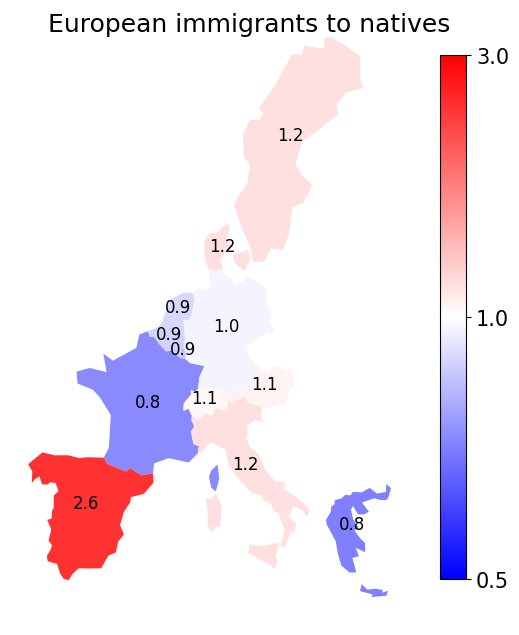

In [55]:
# Ratio: European immigrants to natives by country
ax = europe_immigrants_to_natives.plot(
    column="euimm_to_native",
    categorical=False,
    legend=True,
    norm = TwoSlopeNorm(vmin = 0.5, vcenter=1, vmax=3),
    legend_kwds={
        "shrink": 0.85,
        "location": "right",
        'ticks': [0.5, 1, 3]
        },
    cmap = "bwr",
    figsize=(8, 8))

europe_immigrants_to_natives.apply(
    lambda x: ax.annotate(
        text=round(x['euimm_to_native'], 1),
        xy=x.geometry.centroid.coords[0],
        ha='center', size=12),
    axis=1)
plt.title('European immigrants to natives', fontsize=18, x=0.6, y=0.95)
ax.figure.axes[1].tick_params(labelsize=15)
ax.figure.axes[0].axis('off')
#plt.tight_layout()
plt.show()

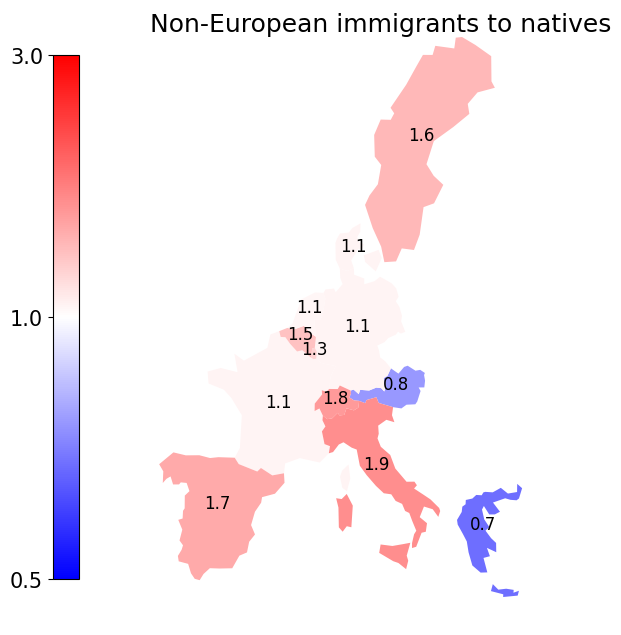

In [53]:
# Ratio: non-European immigrants to natives by country
ax = europe_immigrants_to_natives.plot(
    column="neimm_to_native",
    categorical=False,
    legend=True,
    norm = TwoSlopeNorm(vmin = 0.5, vcenter=1, vmax=3),
    legend_kwds={
        "shrink": 0.85,
        "location": "left",
        'ticks': [0.5, 1, 3]
        },
    cmap = "bwr",
    figsize=(8, 8))

europe_immigrants_to_natives.apply(
    lambda x: ax.annotate(
        text=round(x['neimm_to_native'], 1),
        xy=x.geometry.centroid.coords[0],
        ha='center', size=12),
    axis=1)
plt.title('Non-European immigrants to natives', fontsize=18, x=0.6, y=0.95)
ax.figure.axes[1].tick_params(labelsize=15)
ax.figure.axes[0].axis('off')
#plt.tight_layout()
plt.show()

# With sampe of immigrants who migrated before age 20

### 1. Over sample

In [89]:
# With sampe of immihgrants who migrated before age 20

countries_filter2 = [
    "Austria", "Belgium", "Denmark", "France",
    "Germany", "Greece", "Italy", "Luxembourg",
    "Netherlands", "Spain", "Sweden", "Switzerland"
]

# subset this long dataframe that excludes some coutries of interview and people who immigranted after age 20
# also remove the observations where age is younger than 21 or older than 60
data_long_subset_migb20 = data_long[data_long["country"].isin(countries_filter2)]
data_long_subset_migb20 = data_long_subset_migb20[(data_long_subset_migb20["migrant_age"] < 21) | (data_long_subset_migb20["migrant_age"].isna())]
data_long_subset_migb20 = data_long_subset_migb20[data_long_subset_migb20["age"] > 20] # the age limit was alredy set to 60 earlier


manager_professional_long_migb20 = data_long_subset_migb20.copy()[["age", "gender", "education_tertiary",
                                                     "native_or_immigrant", "manager_professional_ever_cumulative"]]

manager_professional_long_migb20["native_or_immigrant"] = manager_professional_long_migb20["native_or_immigrant"].case_when(
    [
        (manager_professional_long_migb20["native_or_immigrant"] == 'Native', 'Natives'),
        (manager_professional_long_migb20["native_or_immigrant"] == 'European immigrant', 'European immigrants'),
        (manager_professional_long_migb20["native_or_immigrant"] == 'Non-European immigrant', 'Non-European immigrants')
    ]
)

manager_professional_long_migb20["native_or_immigrant"] = manager_professional_long_migb20["native_or_immigrant"].astype('category').cat.reorder_categories(
    ['Natives',
     'European immigrants',
     'Non-European immigrants'
     ])

manager_professional_long_migb20["gender_education"] = manager_professional_long_migb20["gender"].case_when(
    [
        ((manager_professional_long_migb20["gender"] == "Female") & (manager_professional_long_migb20["education_tertiary"] == "Tertiary education"), "Female, tertiary"),
        ((manager_professional_long_migb20["gender"] == "Female") & (manager_professional_long_migb20["education_tertiary"] == "Lower education"), "Female, lower"),
        ((manager_professional_long_migb20["gender"] == "Male") & (manager_professional_long_migb20["education_tertiary"] == "Tertiary education"), "Male, tertiary"),
        ((manager_professional_long_migb20["gender"] == "Male") & (manager_professional_long_migb20["education_tertiary"] == "Lower education"), "Male, lower")
    ]
)

manager_professional_long_migb20["gender_education"] = manager_professional_long_migb20["gender_education"].astype('category').cat.reorder_categories(
    ["Female, tertiary",
     "Female, lower",
     "Male, tertiary",
     "Male, lower"
     ])


# summarize proportion of ever in a manager or professional job position by age (cumulative) and by immigrant groups

# compile the list of dataframes to merge
manager_professional_long_migb20_by_immigrant_frames = []

immigrant_group = ["Natives", "European immigrants", "Non-European immigrants"]
immigrant_short = ["native", "euimm", "neimm"]

for group, short in zip(immigrant_group, immigrant_short):
    
    df = pd.crosstab(
        manager_professional_long_migb20.loc[manager_professional_long_migb20["native_or_immigrant"] == f"{group}", "age"],
        manager_professional_long_migb20.loc[manager_professional_long_migb20["native_or_immigrant"] == f"{group}", "manager_professional_ever_cumulative"],
        normalize = "index").reset_index()
    
    globals()[f"manager_professional_migb20_{short}"] = df.melt(
        id_vars = 'age',
        value_vars = [c for c in list(df) if c != "age"],
        value_name = "proportion"
    )

    globals()[f"manager_professional_migb20_{short}"]["native_or_immigrant"] = f"{group}"
    
    print(f"Table manager_professional_migb20_{short} created successfully!")

    # compile the list of dataframes to merge
    manager_professional_long_migb20_by_immigrant_frames.append(globals()[f"manager_professional_migb20_{short}"])

# merge all 3 groups
manager_professional_long_migb20_by_immigrant = reduce(lambda  left, right: pd.concat([left, right], ignore_index=True), manager_professional_long_migb20_by_immigrant_frames)
print("All dataframes merged!")

manager_professional_long_migb20_by_immigrant = manager_professional_long_migb20_by_immigrant[manager_professional_long_migb20_by_immigrant["manager_professional_ever_cumulative"] == 1]
manager_professional_long_migb20_by_immigrant = manager_professional_long_migb20_by_immigrant.drop("manager_professional_ever_cumulative", axis = 1)

Table manager_professional_migb20_native created successfully!
Table manager_professional_migb20_euimm created successfully!
Table manager_professional_migb20_neimm created successfully!
All dataframes merged!


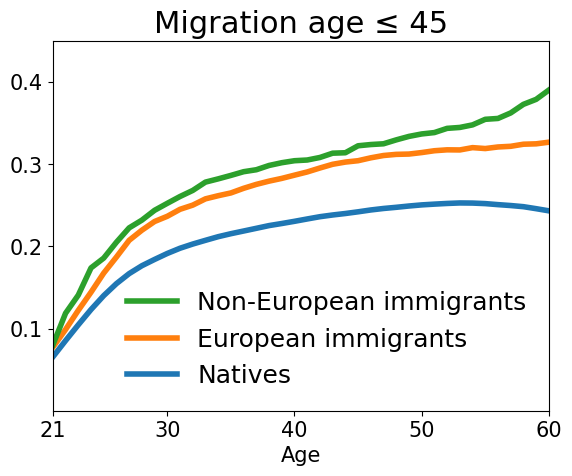

In [431]:
sns.lineplot(data = manager_professional_long_by_immigrant,
             x = "age",
             y = "proportion",
             hue = "native_or_immigrant",
             linewidth = 4
            )

plt.title('Migration age ≤ 45', fontsize=22)
plt.xlabel('Age', fontsize=15)
plt.ylabel('')
plt.xticks(ticks = (21, 30, 40, 50, 60), fontsize = 15)
plt.yticks(ticks = (0.1, 0.2, 0.3, 0.4), fontsize = 15)
plt.ylim(0, 0.45)
plt.legend(reverse = True, frameon=False, loc = "lower right", fontsize = 18).set_title("")
plt.margins(0)
plt.show()

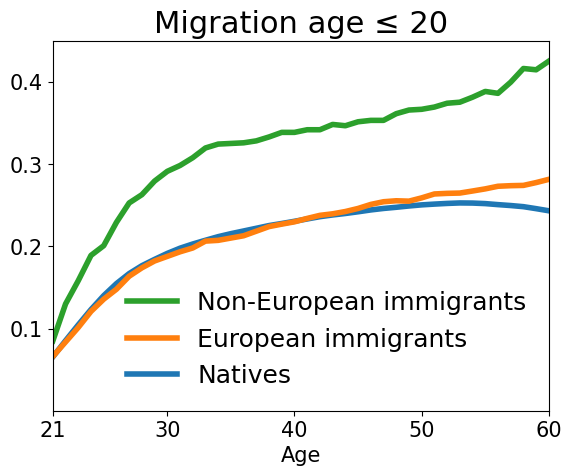

In [432]:
sns.lineplot(data = manager_professional_long_migb20_by_immigrant,
             x = "age",
             y = "proportion",
             hue = "native_or_immigrant",
             linewidth = 4
            )

plt.title('Migration age ≤ 20', fontsize=22)
plt.xlabel('Age', fontsize=15)
plt.ylabel('')
plt.xticks(ticks = (21, 30, 40, 50, 60), fontsize = 15)
plt.yticks(ticks = (0.1, 0.2, 0.3, 0.4), fontsize = 15)
plt.ylim(0, 0.45)
plt.legend(reverse = True, frameon=False, loc = "lower right", fontsize = 18).set_title("")
plt.margins(0)
plt.show()

In [90]:
countries_filter2 = [
    "Austria", "Belgium", "Denmark", "France",
    "Germany", "Greece", "Italy", "Luxembourg",
    "Netherlands", "Spain", "Sweden", "Switzerland"
]

# subset this wide dataframe that excludes some coutries of interview and people who immigranted after age 20
data_wide_subset_migb20 = data_wide[data_wide["country"].isin(countries_filter2)]

data_wide_subset_migb20 = data_wide[data_wide["country"].isin(countries_filter2)]
data_wide_subset_migb20 = data_wide_subset_migb20[(data_wide_subset_migb20["migrant_age"] < 21) | (data_wide_subset_migb20["migrant_age"].isna())]


data_wide_subset_migb20["native_or_immigrant"] = data_wide_subset_migb20["native_or_immigrant"].case_when(
    [
        (data_wide_subset_migb20["native_or_immigrant"] == 'Native', 'Natives'),
        (data_wide_subset_migb20["native_or_immigrant"] == 'European immigrant', 'European immigrants'),
        (data_wide_subset_migb20["native_or_immigrant"] == 'Non-European immigrant', 'Non-European immigrants')
    ]
)

data_wide_subset_migb20["native_or_immigrant"] = data_wide_subset_migb20["native_or_immigrant"].astype('category').cat.reorder_categories(
    ['Natives',
     'European immigrants',
     'Non-European immigrants'
     ])

In [ ]:
pd.crosstab(data_wide_subset_migb20.country,
            data_wide_subset_migb20.native_or_immigrant)

native_or_immigrant,Natives,European immigrants,Non-European immigrants
country,,,
Austria,3332,104,16
Belgium,5621,188,89
Denmark,3919,34,19
France,4067,139,147
Germany,4320,176,18
Greece,4093,22,20
Italy,5387,24,20
Luxembourg,836,116,8
Netherlands,2034,8,34


C:\Users\Jianji Chen\AppData\Local\Temp\ipykernel_19836\4113048641.py:19: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])


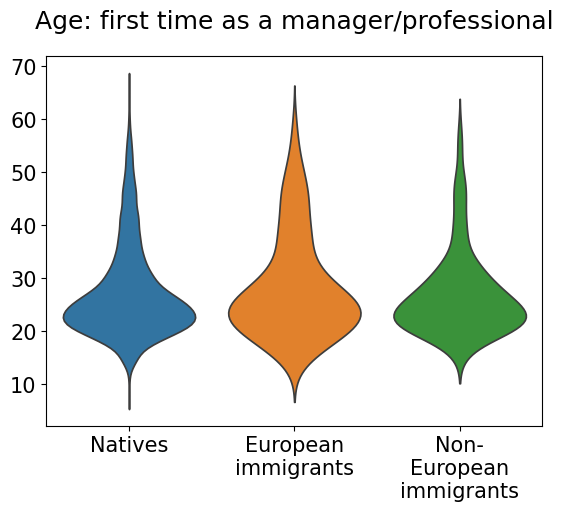

In [ ]:
## age when first in such a position



fig, ax = plt.subplots()

sns.violinplot(data = data_wide_subset_migb20,
               x = "native_or_immigrant",
               y = "manager_professional_1stage",
               inner = None,
               hue = "native_or_immigrant",
            )

plt.title('Age: first time as a manager/professional', fontsize=18, pad=20)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize = 15)
plt.xticks(fontsize = 15)
ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])
plt.legend().remove()
plt.show()

### 2. By gender and education level

In [91]:
# summarize proportion of ever in a manager or professional job position by age (cumulative) and by immigrant groups and gender & education

# compile the list of dataframes to merge
manager_professional_long_migb20_by_immigrant_gender_education_frames = []

immigrant_group = ["Natives", "European immigrants", "Non-European immigrants"]
immigrant_short = ["native", "euimm", "neimm"]

for group, short in zip(immigrant_group, immigrant_short):

    for gender_education, gen_edu in zip(manager_professional_long_migb20.gender_education.unique(), ["female_tertiary", "female_other", "male_tertiary", "male_other"]):
    
        df = pd.crosstab(
            manager_professional_long_migb20.loc[(manager_professional_long_migb20["native_or_immigrant"] == f"{group}") & (manager_professional_long_migb20["gender_education"] == f"{gender_education}"), "age"],
            manager_professional_long_migb20.loc[(manager_professional_long_migb20["native_or_immigrant"] == f"{group}") & (manager_professional_long_migb20["gender_education"] == f"{gender_education}"), "manager_professional_ever_cumulative"],
            normalize = "index").reset_index()
        
        globals()[f"manager_professional_{short}_{gen_edu}"] = df.melt(
            id_vars = 'age',
            value_vars = [c for c in list(df) if c != "age"],
            value_name = "proportion"
        )

        globals()[f"manager_professional_{short}_{gen_edu}"]["native_or_immigrant"] = f"{group}"

        globals()[f"manager_professional_{short}_{gen_edu}"]["gender_education"] = f"{gender_education}"
        
        print(f"Table manager_professional_{short}_{gen_edu} created successfully!")

        # compile the list of dataframes to merge
        manager_professional_long_migb20_by_immigrant_gender_education_frames.append(globals()[f"manager_professional_{short}_{gen_edu}"])

# merge all 3 groups
manager_professional_long_migb20_by_immigrant_gender_education = reduce(lambda  left, right: pd.concat([left, right], ignore_index=True), manager_professional_long_migb20_by_immigrant_gender_education_frames)
print("All dataframes merged!")

manager_professional_long_migb20_by_immigrant_gender_education = manager_professional_long_migb20_by_immigrant_gender_education[manager_professional_long_migb20_by_immigrant_gender_education["manager_professional_ever_cumulative"] == 1]
manager_professional_long_migb20_by_immigrant_gender_education = manager_professional_long_migb20_by_immigrant_gender_education.drop("manager_professional_ever_cumulative", axis = 1)

manager_professional_long_migb20_by_immigrant_gender_education["gender_education"] = manager_professional_long_migb20_by_immigrant_gender_education["gender_education"].astype('category').cat.reorder_categories(
    ["Female, tertiary",
     "Female, lower",
     "Male, tertiary",
     "Male, lower"
     ])

Table manager_professional_native_female_tertiary created successfully!
Table manager_professional_native_female_other created successfully!
Table manager_professional_native_male_tertiary created successfully!
Table manager_professional_native_male_other created successfully!
Table manager_professional_euimm_female_tertiary created successfully!
Table manager_professional_euimm_female_other created successfully!
Table manager_professional_euimm_male_tertiary created successfully!
Table manager_professional_euimm_male_other created successfully!
Table manager_professional_neimm_female_tertiary created successfully!
Table manager_professional_neimm_female_other created successfully!
Table manager_professional_neimm_male_tertiary created successfully!
Table manager_professional_neimm_male_other created successfully!
All dataframes merged!


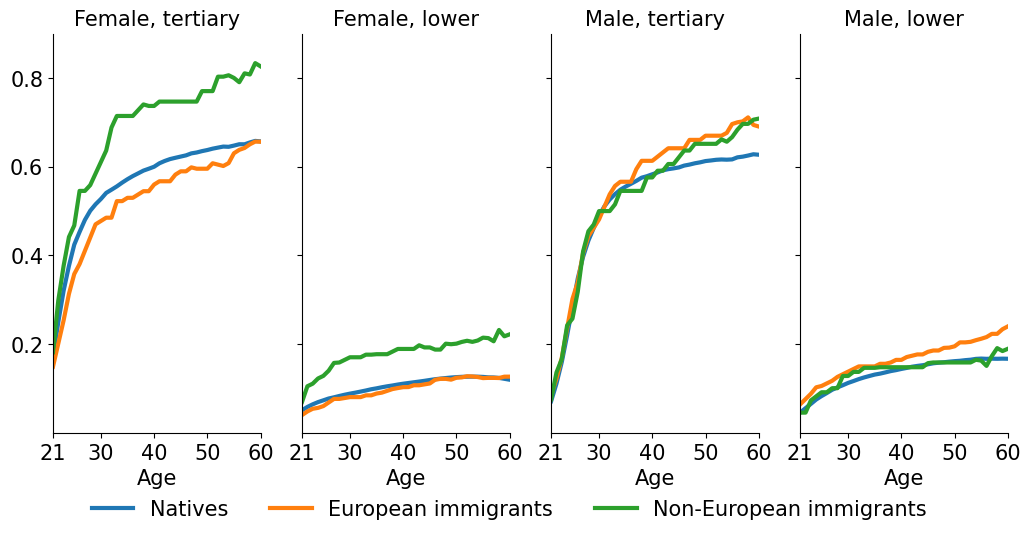

In [132]:
g_migb20_immigrant_gender_education = sns.FacetGrid(manager_professional_long_migb20_by_immigrant_gender_education, col = "gender_education",
                                             height = 3, aspect = 1.5, col_wrap=4)

g_migb20_immigrant_gender_education.map_dataframe(sns.lineplot,
                                 x = "age",
                                 y = "proportion",
                                 hue = "native_or_immigrant",
                                 linewidth = 3
                                 )

g_migb20_immigrant_gender_education.set_titles('{col_name}', size=15)
g_migb20_immigrant_gender_education.fig.subplots_adjust(top=0.86) # adjust the Figure in rp
#g_migb20_immigrant_gender_education.fig.suptitle('Ratio: ever as a manager/professional', fontsize=18)
g_migb20_immigrant_gender_education.set_xlabels("Age", fontsize=15)
g_migb20_immigrant_gender_education.set_ylabels("")
g_migb20_immigrant_gender_education.set(xticks=(21, 30, 40, 50, 60))
g_migb20_immigrant_gender_education.set(yticks=np.arange(0.2, 0.9, step=0.2))
g_migb20_immigrant_gender_education.tick_params(axis='both', labelsize=15)
plt.xlim(21, 60)
plt.ylim(0, 0.9)
plt.legend(reverse = False, frameon=False, bbox_to_anchor=(0.7, -0.12), ncol = 3, fontsize = 15).set_title("")
plt.subplots_adjust(hspace=0, wspace=0.2)
plt.margins(0)
g_migb20_immigrant_gender_education.figure.set_size_inches(10,6)
plt.show()

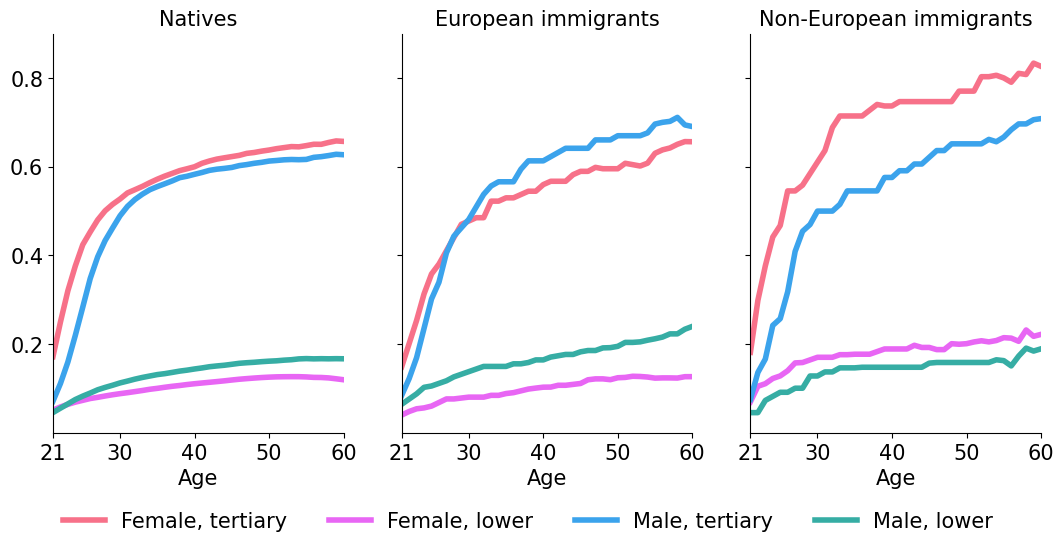

In [106]:
g_migb20_immigrant_gender_education = sns.FacetGrid(manager_professional_long_migb20_by_immigrant_gender_education, col = "native_or_immigrant",
                                             height = 3, aspect = 1.5, col_wrap=4)

g_migb20_immigrant_gender_education.map_dataframe(sns.lineplot,
                                 x = "age",
                                 y = "proportion",
                                 hue = "gender_education",
                                 linewidth = 4,
                                 alpha = 1,
                                 palette = ['#f77189', '#e866f4', '#3ba3ec', '#36ada4']
                                 )

g_migb20_immigrant_gender_education.set_titles('{col_name}', size=15)
g_migb20_immigrant_gender_education.fig.subplots_adjust(top=0.86) # adjust the Figure in rp
#g_migb20_immigrant_gender_education.fig.suptitle('Ratio: ever as a manager/professional', fontsize=18)
g_migb20_immigrant_gender_education.set_xlabels("Age", fontsize=15)
g_migb20_immigrant_gender_education.set_ylabels("")
g_migb20_immigrant_gender_education.set(xticks=(21, 30, 40, 50, 60))
g_migb20_immigrant_gender_education.set(yticks=np.arange(0.2, 0.9, step=0.2))
g_migb20_immigrant_gender_education.tick_params(axis='both', labelsize=15)
plt.xlim(21, 60)
plt.ylim(0, 0.9)
plt.legend(reverse = False, frameon=False, bbox_to_anchor=(0.9, -0.15), ncol = 4, fontsize = 15).set_title("")
plt.subplots_adjust(hspace=0, wspace=0.2)
plt.margins(0)
g_migb20_immigrant_gender_education.figure.set_size_inches(14,6)
plt.show()

In [93]:
data_wide_migb20_subset_4group = data_wide_subset.copy()

data_wide_migb20_subset_4group["gender_education"] = data_wide_migb20_subset_4group["gender"].case_when(
    [
        ((data_wide_migb20_subset_4group["gender"] == "Female") & (data_wide_migb20_subset_4group["education_tertiary"] == "Tertiary education"), "Female, tertiary"),
        ((data_wide_migb20_subset_4group["gender"] == "Female") & (data_wide_migb20_subset_4group["education_tertiary"] == "Lower education"), "Female, lower"),
        ((data_wide_migb20_subset_4group["gender"] == "Male") & (data_wide_migb20_subset_4group["education_tertiary"] == "Tertiary education"), "Male, tertiary"),
        ((data_wide_migb20_subset_4group["gender"] == "Male") & (data_wide_migb20_subset_4group["education_tertiary"] == "Lower education"), "Male, lower")
    ]
)

data_wide_migb20_subset_4group["gender_education"] = data_wide_migb20_subset_4group["gender_education"].astype('category').cat.reorder_categories(
    ["Female, tertiary",
     "Female, lower",
     "Male, tertiary",
     "Male, lower"
     ])

C:\Users\Jianji Chen\AppData\Local\Temp\ipykernel_36548\1484764992.py:21: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])


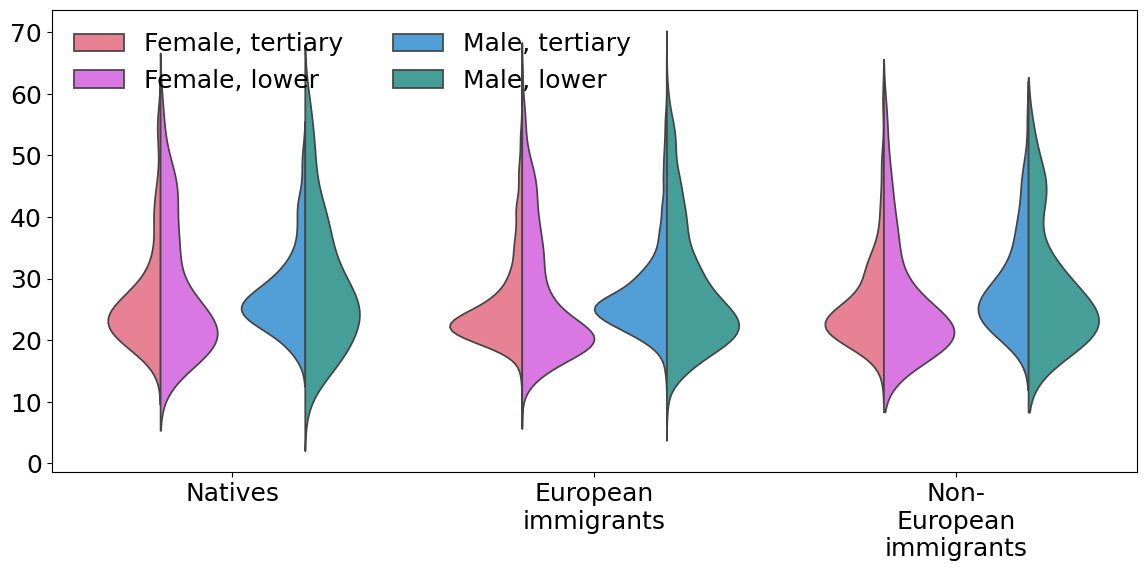

In [94]:
## age when first in such a position



fig, ax = plt.subplots()

sns.violinplot(data = data_wide_migb20_subset_4group,
               x = "native_or_immigrant",
               y = "manager_professional_1stage",
               inner = None,
               hue = "gender_education",
               split=True,
               palette=['#f77189', '#e866f4', '#3ba3ec', '#36ada4']
            )

#plt.title('Age: first time as a manager/professional', fontsize=18, pad=20)
plt.xlabel('')
plt.ylabel('')
plt.yticks(fontsize = 18)
plt.xticks(fontsize = 18)
ax.set_xticklabels([ '\n'.join(wrap(l, 10)) for l in immigrant_group])
plt.legend(reverse = False, frameon=False, loc = "upper left", ncol = 2, fontsize = 18).set_title("")
fig.figure.set_size_inches(14,6)
plt.show()